In [ ]:

# =============================================================================
# 1. 데이터 로드 및 전처리 (Feature Engineering)
# =============================================================================
def make_features(df):
    """
    df: 'date', 'ticker' 컬럼이 반드시 포함되어야 함
    """
    # 원본 훼손 방지
    df = df.copy()
    
    # [중요] 날짜가 문자열이면 datetime으로 변환 (비교 및 정렬용)
    if df['date'].dtype == 'object':
        df['date'] = pd.to_datetime(df['date'])
        
    # [중요] 종목별, 날짜별로 정렬해야 shift/rolling이 정확하게 먹힘
    df = df.sort_values(by=['ticker', 'date'])
    
    # -------------------------------------------------------------------------
    # 팩터 생성 (groupby 'ticker' 후 transform 사용 추천)
    # transform을 쓰면 원본 df의 행 개수가 유지되어 합치기 편합니다.
    # -------------------------------------------------------------------------
    
    # 1. S1_MOM_10D: 최근 10일 수익률
    df['S1_MOM_10D'] = df.groupby('ticker')['close'].pct_change(periods=10)
    
    # 2. S2_VOL_RATIO: 거래대금 급증 (최근 3일 / 10일)
    # rolling은 groupby 객체에 직접 적용
    vol_3d = df.groupby('ticker')['amount'].rolling(window=3).mean().reset_index(0, drop=True)
    vol_10d = df.groupby('ticker')['amount'].rolling(window=10).mean().reset_index(0, drop=True)
    df['S2_VOL_RATIO'] = vol_3d / vol_10d
    
    # 3. S3_INTRADAY_10D: 장중 매수 강도 10일 평균
    # 먼저 컬럼 연산 후 rolling 적용
    df['intraday_temp'] = (df['close'] / df['open']) - 1
    df['S3_INTRADAY_10D'] = df.groupby('ticker')['intraday_temp'].rolling(window=10).mean().reset_index(0, drop=True)
    
    # 4. S4_NEWS_SENT_5D: 뉴스 감성 5일 이동평균
    df['S4_NEWS_SENT_5D'] = df.groupby('ticker')['news_sent'].rolling(window=5).mean().reset_index(0, drop=True)
    
    # 5. S5_SMART_MONEY_10D: (외국인+기관) / 시가총액
    df['smart_sum'] = df['net_buy_frgn'] + df['net_buy_inst']
    smart_rolling = df.groupby('ticker')['smart_sum'].rolling(window=10).sum().reset_index(0, drop=True)
    df['S5_SMART_MONEY_10D'] = smart_rolling / df['market_cap']
    
    # 6. RSI_14: 과열 지표
    # RSI 계산 함수 내부 정의
    def calc_rsi(x):
        delta = x.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
        
    df['RSI_14'] = df.groupby('ticker')['close'].transform(calc_rsi)
    
    # --- [Target] 10일 뒤 수익률 (정답지) ---
    # shift(-10)을 해서 미래 데이터를 현재로 당겨옴
    # groupby 후 shift를 해야 다른 종목 데이터를 안 가져옴
    df['target_return_10d'] = df.groupby('ticker')['close'].shift(-10) / df['close'] - 1
    
    # 임시 컬럼 제거
    df = df.drop(columns=['intraday_temp', 'smart_sum'], errors='ignore')
    
    return df

# (예시 데이터 생성: date가 컬럼으로 있음)
dates = pd.date_range('2015-01-01', '2024-12-31', freq='B')
tickers = ['005930', '000660', '035420', '005380', '006400']
data_list = []
for t in tickers:
    temp = pd.DataFrame({'date': dates})
    temp['ticker'] = t
    temp['close'] = np.random.uniform(50000, 100000, size=len(dates))
    temp['open'] = temp['close'] * np.random.uniform(0.98, 1.02, size=len(dates))
    temp['amount'] = np.random.uniform(1e6, 1e7, size=len(dates))
    temp['market_cap'] = np.random.uniform(1e12, 1e13, size=len(dates))
    temp['net_buy_frgn'] = np.random.uniform(-1e9, 1e9, size=len(dates))
    temp['net_buy_inst'] = np.random.uniform(-1e9, 1e9, size=len(dates))
    temp['news_sent'] = np.random.uniform(0, 1, size=len(dates))
    data_list.append(temp)

df_raw = pd.concat(data_list, ignore_index=True) # 인덱스는 0,1,2... 정수형

# -----------------------------------------------------------------------------

print("1. 팩터 생성 중...")
# make_features 함수 호출
df_processed = make_features(df_raw)

# 학습에 사용할 팩터 정의
features = [
    'S1_MOM_10D', 'S2_VOL_RATIO', 'S3_INTRADAY_10D', 
    'S4_NEWS_SENT_5D', 'S5_SMART_MONEY_10D', 'RSI_14'
]

# 결측치 제거
df_clean = df_processed.dropna(subset=['target_return_10d'] + features)

In [1]:
!pip install xgboost

You should consider upgrading via the 'c:\users\amyda\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [5]:
import pandas as pd
df = pd.read_csv('../단기모멘텀.csv', dtype={'ticker':str})

In [7]:
df.columns

Index(['date', '시가', '고가', '저가', '종가', '거래량', '등락률', 'ticker', 'ret_1d',
       'ret_5d', 'ret_20d'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr



# df['date'] 컬럼을 이용해 불리언 인덱싱(Boolean Indexing)으로 나눕니다.
# .copy()를 써서 경고 메시지(SettingWithCopyWarning) 방지
train_df = df_clean[(df_clean['date'] >= '2015-01-01') & (df_clean['date'] <= '2019-12-31')].copy()
val_df   = df_clean[(df_clean['date'] >= '2020-01-01') & (df_clean['date'] <= '2021-12-31')].copy()
test_df  = df_clean[(df_clean['date'] >= '2022-01-01') & (df_clean['date'] <= '2024-12-31')].copy()

# 학습용 X, y 생성 (date, ticker 컬럼은 학습 데이터 X에서 제외해야 함!)
X_train, y_train = train_df[features], train_df['target_return_10d']
X_val,   y_val   = val_df[features],   val_df['target_return_10d']
X_test,  y_test  = test_df[features],  test_df['target_return_10d']

print(f" - Train: {len(X_train)} / Val: {len(X_val)} / Test: {len(X_test)}")

# =============================================================================
# 3. XGBoost 학습
# =============================================================================
print("3. 모델 학습 시작...")

model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    early_stopping_rounds=50
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)
print(" - 모델 학습 완료!")

# =============================================================================
# 4. 예측 및 날짜별 랭킹 산출
# =============================================================================
print("4. 예측 및 랭킹 산출 중...")

# 예측값 생성
test_pred = model.predict(X_test)

# 결과용 DF 생성 (분석을 위해 date, ticker 포함)
result_df = test_df[['date', 'ticker', 'close', 'target_return_10d']].copy()
result_df['Predicted_Return'] = test_pred

# [핵심 변경] groupby('date')를 사용하여 날짜 컬럼 기준으로 그룹화
# date가 컬럼이므로 바로 문자열 'date'를 넘겨줍니다.
result_df['Score'] = result_df.groupby('date')['Predicted_Return'].rank(pct=True, ascending=True) * 100
result_df['Rank'] = result_df.groupby('date')['Predicted_Return'].rank(method='min', ascending=False)

# =============================================================================
# 5. 성과 평가
# =============================================================================
print("\n" + "="*40)
print("       [모델 성능 평가 리포트]       ")
print("="*40)

# 1. RMSE
rmse = np.sqrt(mean_squared_error(y_test, test_pred))

# 2. Accuracy
hit = np.sign(y_test) == np.sign(test_pred)
accuracy = hit.mean()

# 3. IC (날짜 컬럼 기준 Groupby)
# 데이터가 너무 적은 날짜는 제외하는 로직 추가
def get_ic(group):
    if len(group) < 2: return np.nan
    return spearmanr(group['target_return_10d'], group['Predicted_Return'])[0]

ic = result_df.groupby('date').apply(get_ic).mean()

# 4. Top 10 수익률
top10_returns = []
for date_val, group in result_df.groupby('date'):
    top10_picks = group.nsmallest(10, 'Rank')
    if not top10_picks.empty:
        top10_returns.append(top10_picks['target_return_10d'].mean())

avg_top10_return = np.mean(top10_returns)

print(f"1. RMSE (오차)             : {rmse:.5f}")
print(f"2. Directional Accuracy    : {accuracy * 100:.2f}%")
print(f"3. Information Coefficient : {ic:.4f}")
print(f"4. Top 10 평균 수익률(10일): {avg_top10_return * 100:.2f}%")
print("="*40)

# =============================================================================
# 6. 추천 종목 조회 함수
# =============================================================================
def get_recommendations(date_str, top_n=5):
    # date 컬럼이 datetime 형식이므로 문자열을 변환해서 비교하거나,
    # 문자열로 비교할 수 있게 처리
    target_dt = pd.to_datetime(date_str)
    
    # 해당 날짜 데이터 필터링
    daily_df = result_df[result_df['date'] == target_dt]
    
    if daily_df.empty:
        print(f"\n해당 날짜({date_str}) 데이터가 없습니다.")
        return
        
    top_picks = daily_df.sort_values(by='Rank').head(top_n)
    
    print(f"\n[ {date_str} 단기 트랙 추천 TOP {top_n} ]")
    # 보기 좋게 컬럼 순서 정렬
    print(top_picks[['ticker', 'Predicted_Return', 'Score', 'Rank']])

# 테스트
# 데이터에 있는 마지막 날짜를 찾아서 테스트
last_available_date = result_df['date'].max()
get_recommendations(str(last_available_date.date()))

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr

# =============================================================================
# 1. 데이터 로드 및 전처리 (Feature Engineering)
# =============================================================================
def make_features(df):
    """
    현재 보유 컬럼: ['date', '시가', '고가', '저가', '종가', '거래량', '등락률', 'ticker', 'ret_1d', 'ret_5d', 'ret_20d']
    """
    df = df.copy()
    
    # 1. 날짜 변환 및 정렬 (필수)
    if df['date'].dtype == 'object':
        df['date'] = pd.to_datetime(df['date'])
    
    df = df.sort_values(by=['ticker', 'date'])
    
    # -------------------------------------------------------------------------
    # [팩터 생성] 가격/거래량 위주 (수급/뉴스 제외)
    # -------------------------------------------------------------------------
    
    # F1. MOM_10D (10일 모멘텀)
    # 기존 ret_5d, ret_20d는 있지만 예측 기간인 10일 수익률도 피처로 추가
    df['F1_MOM_10D'] = df.groupby('ticker')['종가'].pct_change(periods=10)
    
    # F2. VOL_RATIO (거래량 급증)
    # 거래대금 대신 '거래량' 사용 (최근 3일 평균 / 10일 평균)
    vol_3d = df.groupby('ticker')['거래량'].rolling(window=3).mean().reset_index(0, drop=True)
    vol_10d = df.groupby('ticker')['거래량'].rolling(window=10).mean().reset_index(0, drop=True)
    df['F2_VOL_RATIO'] = vol_3d / vol_10d
    
    # F3. RSI_14 (과열 지표)
    def calc_rsi(x):
        delta = x.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
        
    df['F3_RSI_14'] = df.groupby('ticker')['종가'].transform(calc_rsi)
    
    # F4. VOLATILITY_10D (변동성)
    # 등락률의 10일 표준편차 -> 주가가 요동치는 종목인지 확인
    df['F4_VOLATILITY'] = df.groupby('ticker')['등락률'].rolling(window=10).std().reset_index(0, drop=True)
    
    # F5. INTRADAY_STR (장중 강도)
    # 시가 대비 종가 상승폭 (오늘 장이 셌는지)
    # 0으로 나누는 에러 방지를 위해 시가가 0인 경우 처리 필요할 수 있음
    df['intraday'] = (df['종가'] / df['시가']) - 1
    df['F5_INTRADAY_AVG'] = df.groupby('ticker')['intraday'].rolling(window=5).mean().reset_index(0, drop=True)

    # -------------------------------------------------------------------------
    # [Target] 10일 뒤 수익률 생성
    # -------------------------------------------------------------------------
    df['target_return_10d'] = df.groupby('ticker')['종가'].shift(-10) / df['종가'] - 1
    
    # 임시 컬럼 제거
    df = df.drop(columns=['intraday'], errors='ignore')
    
    return df




# =============================================================================
# 2. 실행 및 모델링
# =============================================================================

# 1. 팩터 생성
print("1. 팩터 생성 중...")
df_processed = make_features(df)

# 2. 학습에 사용할 피처 선택 (보유하신 컬럼 + 새로 만든 팩터)
features = [
    'ret_5d',           # (기존) 단기 추세
    'ret_20d',          # (기존) 중기 추세
    'F1_MOM_10D',       # (신규) 예측 기간과 동일한 모멘텀
    'F2_VOL_RATIO',     # (신규) 거래량 급증
    'F3_RSI_14',        # (신규) 과열 지표
    'F4_VOLATILITY',    # (신규) 리스크/변동성
    'F5_INTRADAY_AVG'   # (신규) 최근 장중 매수세
]

# 결측치 제거
df_clean = df_processed.dropna(subset=['target_return_10d'] + features)

# 3. 데이터 기간 분할 (Train/Val/Test)
print("2. 데이터 분할 중...")
train_df = df_clean[(df_clean['date'] >= '2015-01-01') & (df_clean['date'] <= '2019-12-31')]
val_df   = df_clean[(df_clean['date'] >= '2020-01-01') & (df_clean['date'] <= '2021-12-31')]
test_df  = df_clean[(df_clean['date'] >= '2022-01-01') & (df_clean['date'] <= '2024-12-31')]

X_train, y_train = train_df[features], train_df['target_return_10d']
X_val,   y_val   = val_df[features],   val_df['target_return_10d']
X_test,  y_test  = test_df[features],  test_df['target_return_10d']

# 4. XGBoost 모델 학습
print("3. 모델 학습 시작...")
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    early_stopping_rounds=50
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

# 5. 예측 및 결과 정리
print("4. 예측 및 평가 중...")
test_pred = model.predict(X_test)

result_df = test_df[['date', 'ticker', '종가', 'target_return_10d']].copy()
result_df['Predicted_Return'] = test_pred

# 날짜별 랭킹 산출 (Score: 0~100점)
result_df['Score'] = result_df.groupby('date')['Predicted_Return'].rank(pct=True, ascending=True) * 100
result_df['Rank'] = result_df.groupby('date')['Predicted_Return'].rank(method='min', ascending=False)

# 6. 성과 평가 출력
rmse = np.sqrt(mean_squared_error(y_test, test_pred))
# IC 계산 (데이터가 적은 날은 제외)
def get_ic(group):
    if len(group) < 2: return np.nan
    return spearmanr(group['target_return_10d'], group['Predicted_Return'])[0]
ic = result_df.groupby('date').apply(get_ic).mean()

print(f"\n=== 성능 평가 ===")
print(f"RMSE: {rmse:.5f}")
print(f"IC(랭킹 상관계수): {ic:.4f}")

# 변수 중요도 확인 (어떤 컬럼이 가장 중요했나?)
print("\n=== 변수 중요도 (Top 3) ===")
importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print(importance.head(3))

1. 팩터 생성 중...
2. 데이터 분할 중...
3. 모델 학습 시작...
4. 예측 및 평가 중...

=== 성능 평가 ===
RMSE: 0.08366
IC(랭킹 상관계수): -0.0007

=== 변수 중요도 (Top 3) ===
F3_RSI_14        0.153103
ret_20d          0.148755
F4_VOLATILITY    0.146898
dtype: float32


C:\Users\amyda\AppData\Local\Temp\ipykernel_13448\1863982965.py:137: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ic = result_df.groupby('date').apply(get_ic).mean()


In [10]:
def get_ranking_by_date(target_date_str, top_n=10):
    """
    사용법: get_ranking_by_date('2024-01-02')
    """
    # 1. 문자열('2024-01-02')을 datetime 형식으로 변환 (데이터와 비교하기 위해)
    target_dt = pd.to_datetime(target_date_str)

    # 2. 해당 날짜 데이터만 필터링
    daily_df = result_df[result_df['date'] == target_dt].copy()

    # 데이터가 없는 경우 (휴장일이거나 범위 밖)
    if daily_df.empty:
        print(f"⚠️ {target_date_str} 데이터가 없습니다. (휴장일이거나 Test 기간 아님)")
        return None

    # 3. 랭킹(Rank) 순서대로 정렬 (1등이 맨 위로)
    daily_ranking = daily_df.sort_values(by='Rank', ascending=True)

    # 4. 보기 좋게 출력
    print(f"\n📅 [{target_date_str}] 단기 투자 추천 TOP {top_n}")
    print("-" * 60)
    
    # 보고 싶은 컬럼만 선택해서 출력
    columns_to_show = ['ticker', '종가', 'Predicted_Return', 'Score', 'Rank']
    display_df = daily_ranking[columns_to_show].head(top_n)
    
    # 예측 수익률을 %로 보기 좋게 변환 (선택 사항)
    # display_df['예측수익률(%)'] = (display_df['Predicted_Return'] * 100).round(2).astype(str) + '%'
    
    print(display_df)
    print("-" * 60)
    return display_df

# ======================================================
# [실행 예시] 보고 싶은 날짜를 넣으세요!
# ======================================================

# 예: 2024년 1월 2일 순위 보기
top_stocks = get_ranking_by_date('2024-01-02', top_n=10)

# 예: 데이터에 있는 가장 최근 날짜 순위 보기
last_date = result_df['date'].max() # 가장 마지막 날짜 찾기
get_ranking_by_date(str(last_date.date()))


📅 [2024-01-02] 단기 투자 추천 TOP 10
------------------------------------------------------------
        ticker      종가  Predicted_Return       Score  Rank
393156  180640   78200          0.037673  100.000000   1.0
152152  009420   43200          0.021178   99.494949   2.0
441658  450080  199900          0.019759   98.989899   3.0
220976  022100   69600          0.019404   98.484848   4.0
181648  011200   20600          0.016905   97.979798   5.0
425765  298040  157700          0.012055   97.474747   6.0
409483  259960  195800          0.008090   96.969697   7.0
328942  079550  128300          0.006618   96.464646   8.0
117740  006110  102900          0.006542   95.959596   9.0
442738  457190   33600          0.005651   95.454545  10.0
------------------------------------------------------------

📅 [2024-12-13] 단기 투자 추천 TOP 10
------------------------------------------------------------
        ticker       종가  Predicted_Return       Score  Rank
417393  272210    21750          0.015020  1

,ticker,종가,Predicted_Return,Score,Rank
417393,272210,21750,0.015020,100.000000,1.0
167133,010130,1225000,0.013324,99.497487,2.0
443034,489790,35500,0.011922,98.994975,3.0
439970,377300,33450,0.011066,98.492462,4.0
152385,009420,35000,0.011012,97.989950,5.0
9821,000150,244500,0.010841,97.487437,6.0
304781,064350,49900,0.010037,96.984925,7.0
179423,011170,62900,0.008854,96.482412,8.0
425998,298040,430000,0.008654,95.979899,9.0
194171,012450,318060,0.008350,95.477387,10.0


In [11]:
!pip install matplotlib

You should consider upgrading via the 'c:\users\amyda\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [12]:
!pip install seaborn

You should consider upgrading via the 'c:\users\amyda\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 깨짐 방지 (Windows 환경 기준, Mac은 'AppleGothic')
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

def verify_model_performance(df):
    """
    df: 'Predicted_Return', 'target_return_10d', 'Score' 컬럼이 있는 결과 데이터
    """
    # 데이터가 너무 많으면 보기 힘드니, 랜덤으로 2000개만 샘플링해서 시각화
    sample_df = df.sample(n=min(2000, len(df)), random_state=42)
    
    plt.figure(figsize=(18, 5))
    
    # ---------------------------------------------------------
    # 1. 산점도 (Scatter Plot): 예측 vs 실제
    # ---------------------------------------------------------
    plt.subplot(1, 3, 1)
    sns.scatterplot(x=sample_df['Predicted_Return'], y=sample_df['target_return_10d'], alpha=0.5)
    
    # 기준선 (y=x) 그리기
    m = min(sample_df['Predicted_Return'].min(), sample_df['target_return_10d'].min())
    M = max(sample_df['Predicted_Return'].max(), sample_df['target_return_10d'].max())
    plt.plot([m, M], [m, M], color='red', linestyle='--')
    
    plt.title('예측 수익률 vs 실제 수익률 (Scatter)')
    plt.xlabel('모델이 예측한 수익률')
    plt.ylabel('실제 발생한 10일 수익률')
    plt.grid(True)

    # ---------------------------------------------------------
    # 2. 분위수 분석 (Decile Analysis): 그룹별 성과
    # ---------------------------------------------------------
    plt.subplot(1, 3, 2)
    
    # 점수(Score)를 기준으로 10개 그룹(Decile)으로 나누기
    # qcut: 등수로 자르기 (9 = 상위 10%, 0 = 하위 10%)
    df['Decile'] = pd.qcut(df['Score'], 10, labels=False, duplicates='drop')
    
    # 각 그룹의 '실제 수익률' 평균 계산
    decile_ret = df.groupby('Decile')['target_return_10d'].mean() * 100 # % 단위 변환
    
    # 바 차트 그리기
    colors = ['red' if x == decile_ret.max() else 'gray' for x in decile_ret]
    decile_ret.plot(kind='bar', color=colors)
    plt.title('점수 구간별 실제 수익률 (계단식이어야 좋음)')
    plt.xlabel('점수 그룹 (9:상위10% ~ 0:하위10%)')
    plt.ylabel('평균 실제 수익률 (%)')
    plt.grid

Matplotlib is building the font cache; this may take a moment.


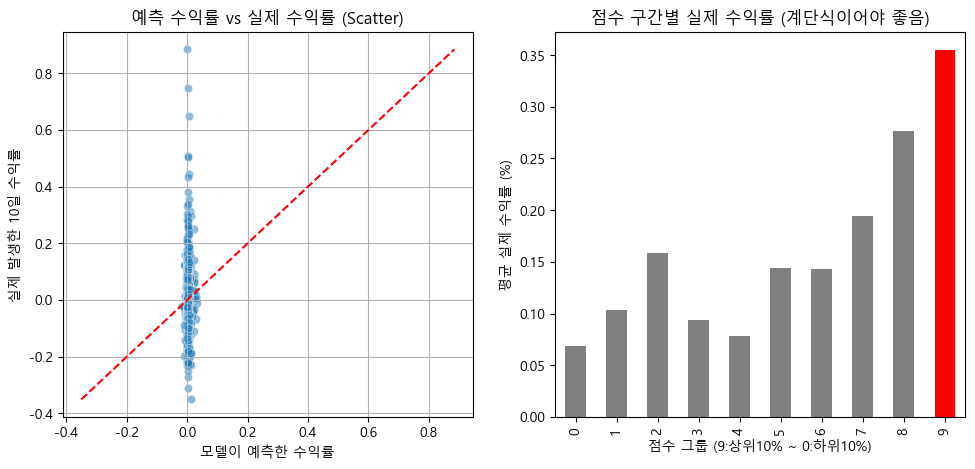

In [14]:
verify_model_performance(result_df)

팩터 생성 중...
데이터 분할 중 (Train/Val/Test)...
모델 학습 시작...
[0]	validation_0-rmse:0.07266	validation_1-rmse:0.10333
[100]	validation_0-rmse:0.07171	validation_1-rmse:0.10293
[123]	validation_0-rmse:0.07156	validation_1-rmse:0.10295
Test 데이터 예측 및 랭킹 산출 중...

[Dual-Track 모델 검증 리포트]


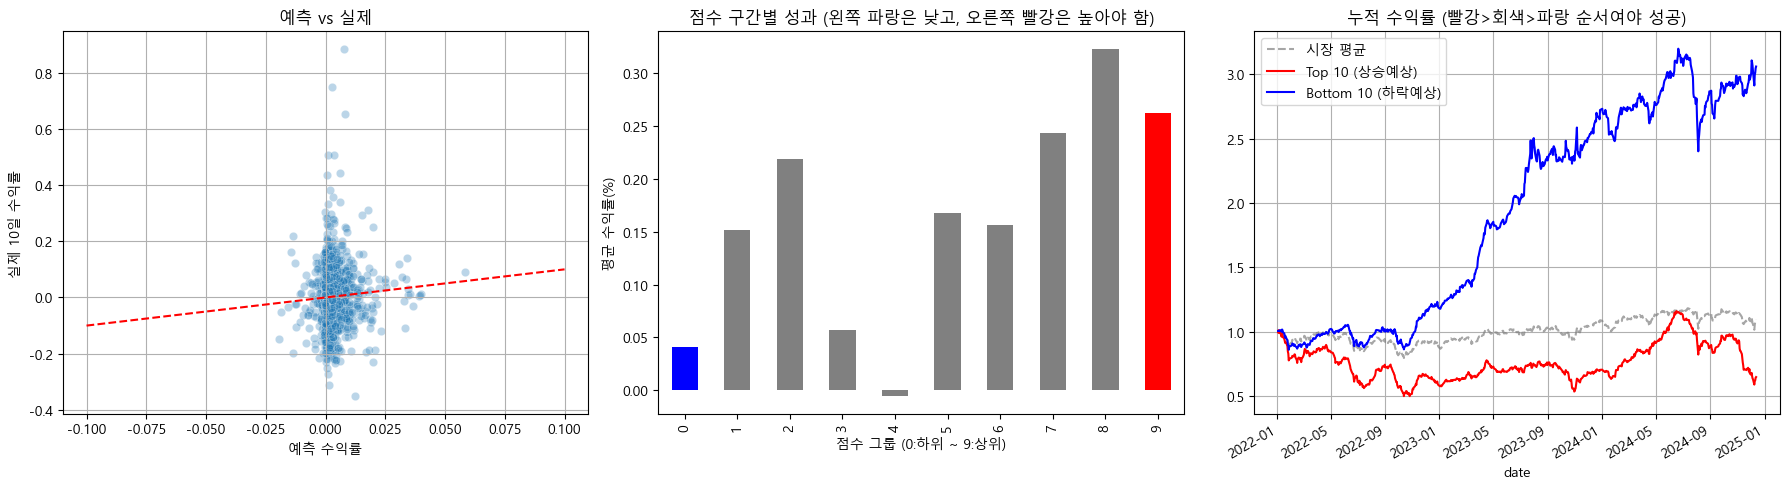


📅 [2024-12-13] KOSPI200 단기 예측 리포트

🔥 상승 예상 Top 10 (매수 추천)
----------------------------------------------------------------------
        ticker      종가  Predicted_Return       Score  Rank
417393  272210   21750          0.020722  100.000000   1.0
439970  377300   33450          0.018423   99.497487   2.0
9821    000150  244500          0.015799   98.994975   3.0
152385  009420   35000          0.014184   98.492462   4.0
304781  064350   49900          0.011795   97.989950   5.0
179423  011170   62900          0.011368   97.487437   6.0
443034  489790   35500          0.010228   96.984925   7.0
425998  298040  430000          0.009381   96.482412   8.0
351297  103140   51300          0.008774   95.979899   9.0
93393   005070   58300          0.008503   95.477387  10.0

❄️ 하락 예상 Bottom 10 (매도/관망 추천)
----------------------------------------------------------------------
        ticker      종가  Predicted_Return     Score   Rank
287575  047050   38950         -0.017450  0.502513  199.0
442

In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr

# -----------------------------------------------------------------------------
# [0] 한글 폰트 설정 (그래프 깨짐 방지)
# -----------------------------------------------------------------------------
import platform
system_name = platform.system()
if system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':  # Mac
    plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

# =============================================================================
# [1] 데이터 로드 (여기에 실제 파일을 넣어주세요!)
# =============================================================================
# ★★★ [중요] 아래 경로를 실제 데이터 파일 경로로 수정하세요 ★★★
# 예: df_raw = pd.read_csv("data/kospi200_data.csv")
# 가지고 계신 컬럼: ['date', '시가', '고가', '저가', '종가', '거래량', '등락률', 'ticker', 'ret_1d', 'ret_5d', 'ret_20d']

# (지금은 파일이 없으니 에러가 나지 않게 주석 처리했습니다. 실제 실행 시 주석을 풀고 경로를 적으세요)
df_raw = df.copy()

# ※ 만약 지금 바로 테스트할 데이터가 없다면, 이 코드는 실행되지 않습니다.
#    데이터를 로드한 변수명을 'df_raw'로 지정해주세요.

# =============================================================================
# [2] 피처 엔지니어링 (팩터 생성)
# =============================================================================
def make_features(df):
    """
    보유 컬럼을 활용해 단기(10일) 예측에 필요한 기술적 지표 생성
    """
    df = df.copy()
    
    # 1. 날짜 변환 및 정렬
    if df['date'].dtype == 'object':
        df['date'] = pd.to_datetime(df['date'])
    
    # 종목별, 날짜별 정렬 (과거->미래 순서 필수)
    df = df.sort_values(by=['ticker', 'date'])
    
    print("팩터 생성 중...")
    
    # --- [New Factors] 기존 데이터로 파생변수 생성 ---
    
    # F1. MOM_10D: 향후 예측 기간(10일)과 동일한 과거 10일 모멘텀
    df['F1_MOM_10D'] = df.groupby('ticker')['종가'].pct_change(periods=10)
    
    # F2. VOL_RATIO: 거래량 급증 (최근 3일 평균 / 10일 평균)
    vol_3d = df.groupby('ticker')['거래량'].rolling(window=3).mean().reset_index(0, drop=True)
    vol_10d = df.groupby('ticker')['거래량'].rolling(window=10).mean().reset_index(0, drop=True)
    df['F2_VOL_RATIO'] = vol_3d / vol_10d
    
    # F3. RSI_14: 과열 지표 (14일 기준)
    def calc_rsi(x):
        delta = x.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    df['F3_RSI_14'] = df.groupby('ticker')['종가'].transform(calc_rsi)
    
    # F4. VOLATILITY: 변동성 (등락률의 10일 표준편차)
    df['F4_VOLATILITY'] = df.groupby('ticker')['등락률'].rolling(window=10).std().reset_index(0, drop=True)
    
    # F5. INTRADAY_AVG: 장중 매수세 (종가/시가) 5일 평균
    df['intraday_temp'] = (df['종가'] / df['시가']) - 1
    df['F5_INTRADAY_AVG'] = df.groupby('ticker')['intraday_temp'].rolling(window=5).mean().reset_index(0, drop=True)
    
    # --- [Target] 10일 뒤 수익률 (정답지) ---
    # shift(-10)으로 미래 데이터를 현재로 가져옴
    df['target_return_10d'] = df.groupby('ticker')['종가'].shift(-10) / df['종가'] - 1
    
    # 불필요한 임시 컬럼 삭제
    df = df.drop(columns=['intraday_temp'], errors='ignore')
    
    return df

# 팩터 생성 실행
# (주의: df_raw가 로드되어 있어야 합니다)
if 'df_raw' in locals():
    df_processed = make_features(df_raw)
else:
    print("⛔ 경고: df_raw 데이터가 로드되지 않았습니다. [1]번 섹션에서 파일을 불러와주세요.")
    # (코드 중단을 막기 위한 빈 데이터프레임)
    df_processed = pd.DataFrame()

# =============================================================================
# [3] 데이터 분할 및 학습 준비
# =============================================================================
# 모델에 사용할 최종 피처 리스트
features = [
    'ret_5d',           # (기존 보유) 단기 추세
    'ret_20d',          # (기존 보유) 중기 추세
    'F1_MOM_10D',       # (신규) 10일 모멘텀
    'F2_VOL_RATIO',     # (신규) 거래량 급증
    'F3_RSI_14',        # (신규) 과열 지표
    'F4_VOLATILITY',    # (신규) 리스크
    'F5_INTRADAY_AVG'   # (신규) 장중 강도
]

# 결측치 제거
df_clean = df_processed.dropna(subset=['target_return_10d'] + features)

print("데이터 분할 중 (Train/Val/Test)...")
train_df = df_clean[(df_clean['date'] >= '2015-01-01') & (df_clean['date'] <= '2019-12-31')]
val_df   = df_clean[(df_clean['date'] >= '2020-01-01') & (df_clean['date'] <= '2021-12-31')]
test_df  = df_clean[(df_clean['date'] >= '2022-01-01') & (df_clean['date'] <= '2024-12-31')]

X_train, y_train = train_df[features], train_df['target_return_10d']
X_val,   y_val   = val_df[features],   val_df['target_return_10d']
X_test,  y_test  = test_df[features],  test_df['target_return_10d']

# =============================================================================
# [4] XGBoost 모델 학습
# =============================================================================
print("모델 학습 시작...")
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,    # 학습률을 조금 낮춰서 안정적으로
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    early_stopping_rounds=50
)

# 학습 진행 (Validation 성능 감시)
if not X_train.empty:
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100  # 100번마다 로그 출력
    )
else:
    print("⛔ 학습 데이터가 없습니다. 날짜 범위나 데이터를 확인해주세요.")

print("Test 데이터 예측 및 랭킹 산출 중...")

if not X_test.empty:
    test_pred = model.predict(X_test)

    # 결과 정리용 DF
    # ★수정★: 백테스트용으로 'ret_1d'(1일 수익률) 컬럼을 꼭 가져와야 함!
    result_df = test_df[['date', 'ticker', '종가', 'ret_1d', 'target_return_10d']].copy()
    result_df['Predicted_Return'] = test_pred

    # 랭킹 산출
    result_df['Score'] = result_df.groupby('date')['Predicted_Return'].rank(pct=True, ascending=True) * 100
    result_df['Rank'] = result_df.groupby('date')['Predicted_Return'].rank(method='min', ascending=False)
else:
    result_df = pd.DataFrame()

# =============================================================================
# [6] 성과 검증 및 시각화 (수익률 버그 수정 버전)
# =============================================================================
def verify_model_dual_track(df):
    if df.empty: return
    
    print("\n[Dual-Track 모델 검증 리포트]")
    
    plt.figure(figsize=(18, 5))
    
    # (1) 산점도 (Scatter)
    plt.subplot(1, 3, 1)
    sample = df.sample(n=min(2000, len(df)), random_state=42)
    sns.scatterplot(x=sample['Predicted_Return'], y=sample['target_return_10d'], alpha=0.3)
    plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--', label='정확한 예측선')
    plt.title('예측 vs 실제')
    plt.xlabel('예측 수익률'); plt.ylabel('실제 10일 수익률')
    plt.grid(True)
    
    # (2) 분위수별 수익률 (Bar)
    plt.subplot(1, 3, 2)
    df['Decile'] = pd.qcut(df['Score'], 10, labels=False, duplicates='drop')
    decile_ret = df.groupby('Decile')['target_return_10d'].mean() * 100
    
    # 색상: 상위(9)=빨강, 하위(0)=파랑, 나머지=회색
    colors = []
    for i in range(len(decile_ret)):
        if i == 9: colors.append('red')    # Top 10%
        elif i == 0: colors.append('blue') # Bottom 10%
        else: colors.append('gray')
        
    decile_ret.plot(kind='bar', color=colors)
    plt.title('점수 구간별 성과 (왼쪽 파랑은 낮고, 오른쪽 빨강은 높아야 함)')
    plt.xlabel('점수 그룹 (0:하위 ~ 9:상위)'); plt.ylabel('평균 수익률(%)')
    
    # (3) 누적 수익률 비교 (Line) - ★Bottom 10 추가됨
    plt.subplot(1, 3, 3)
    
    # 시장 평균
    daily_market = df.groupby('date')['ret_1d'].mean()
    # Top 10% (Score >= 90)
    daily_top = df[df['Score'] >= 90].groupby('date')['ret_1d'].mean()
    # Bottom 10% (Score <= 10)
    daily_bottom = df[df['Score'] <= 10].groupby('date')['ret_1d'].mean()
    
    (1 + daily_market).cumprod().plot(label='시장 평균', linestyle='--', color='gray', alpha=0.7)
    (1 + daily_top).cumprod().plot(label='Top 10 (상승예상)', color='red', linewidth=1.5)
    (1 + daily_bottom).cumprod().plot(label='Bottom 10 (하락예상)', color='blue', linewidth=1.5)
    
    plt.title('누적 수익률 (빨강>회색>파랑 순서여야 성공)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 실행
verify_model_dual_track(result_df)

# =============================================================================
# [7] 유틸리티: 특정 날짜 순위 조회
# =============================================================================
def get_daily_top_bottom(date_str, n=10):
    """
    특정 날짜의 Top N (상승 예상)과 Bottom N (하락 예상)을 조회
    """
    try:
        target_dt = pd.to_datetime(date_str)
        
        # 해당 날짜 데이터 추출
        daily_df = result_df[result_df['date'] == target_dt].copy()
        
        if daily_df.empty:
            print(f"⚠️ {date_str} 데이터가 없습니다. (휴장일이거나 Test 기간 아님)")
            return

        # 랭킹(Rank) 오름차순 정렬 (1등이 맨 위, 꼴등이 맨 아래)
        daily_df = daily_df.sort_values(by='Rank', ascending=True)
        
        # Top 10 (상위 n개)
        top_n_df = daily_df.head(n)
        
        # Bottom 10 (하위 n개)
        bottom_n_df = daily_df.tail(n).sort_values(by='Rank', ascending=False) # 꼴등부터 보이게 다시 정렬

        print(f"\n📅 [{date_str}] KOSPI200 단기 예측 리포트")
        print("=" * 70)
        
        print(f"\n🔥 상승 예상 Top {n} (매수 추천)")
        print("-" * 70)
        print(top_n_df[['ticker', '종가', 'Predicted_Return', 'Score', 'Rank']])

        print(f"\n❄️ 하락 예상 Bottom {n} (매도/관망 추천)")
        print("-" * 70)
        print(bottom_n_df[['ticker', '종가', 'Predicted_Return', 'Score', 'Rank']])
        print("=" * 70)
        
    except Exception as e:
        print("에러 발생:", e)


# [사용 예시] 가장 최근 날짜의 Top/Bottom 10 조회
last_date = str(result_df['date'].max().date())
get_daily_top_bottom(last_date, n=10)


[Dual-Track 모델 검증 리포트]


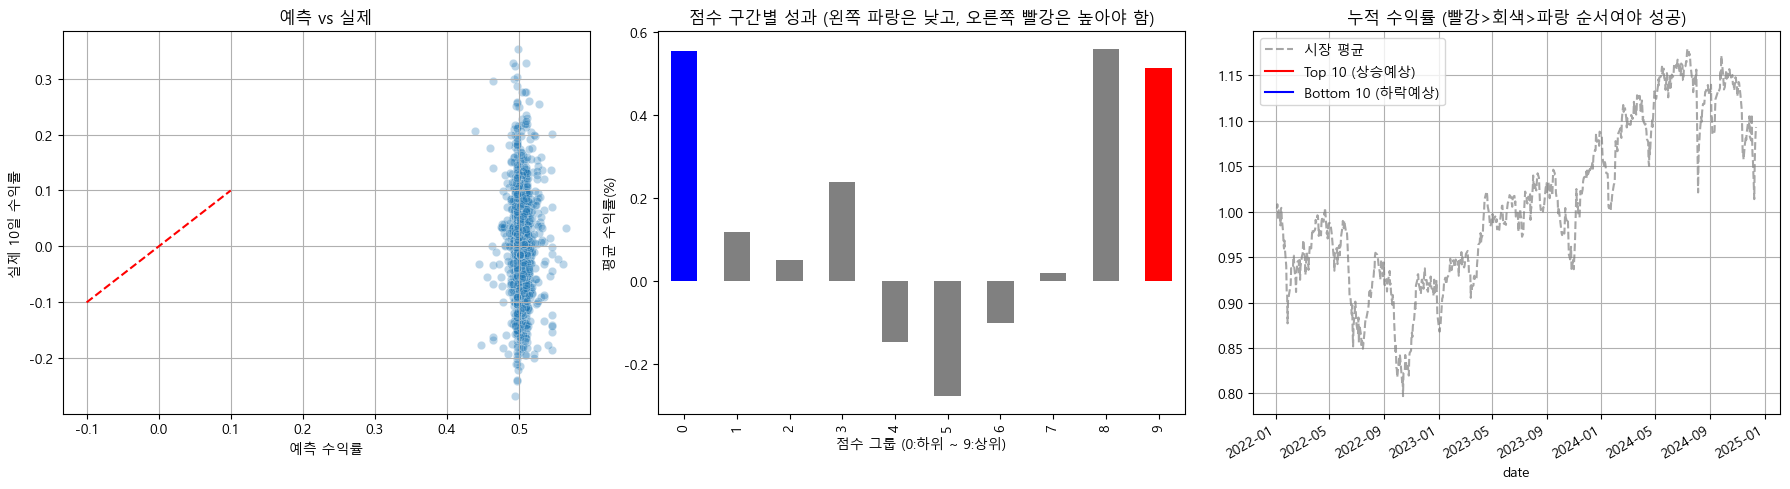

In [ ]:
# =============================================================================
# [2] 피처 엔지니어링 (Target을 'Rank'로 변경)
# =============================================================================
def make_features_rank_version(df):
    df = df.copy()
    if df['date'].dtype == 'object':
        df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by=['ticker', 'date'])
    
    # --- [기술적 지표 생성] (기존과 동일) ---
    # 1. 모멘텀 & 거래량
    df['F1_MOM_10D'] = df.groupby('ticker')['종가'].pct_change(periods=10)
    
    vol_3d = df.groupby('ticker')['거래량'].rolling(3).mean().reset_index(0, drop=True)
    vol_10d = df.groupby('ticker')['거래량'].rolling(10).mean().reset_index(0, drop=True)
    df['F2_VOL_RATIO'] = vol_3d / (vol_10d + 1e-9) # 분모 0 방지
    
    # 2. RSI
    def calc_rsi(x):
        delta = x.diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / (loss + 1e-9)
        return 100 - (100 / (1 + rs))
    df['F3_RSI_14'] = df.groupby('ticker')['종가'].transform(calc_rsi)
    
    # 3. 변동성
    df['F4_VOLATILITY'] = df.groupby('ticker')['등락률'].rolling(10).std().reset_index(0, drop=True)
    
    # --- [NEW] ★핵심 수정: Target을 'Rank'로 변환 ---
    # 1) 먼저 10일 뒤 수익률을 계산
    df['future_return'] = df.groupby('ticker')['종가'].shift(-10) / df['종가'] - 1
    
    # 2) 날짜별로 수익률 '등수(백분위)'를 매김 (0.0 ~ 1.0)
    # 1등은 1.0, 꼴등은 0.0이 됨
    df['target_rank'] = df.groupby('date')['future_return'].rank(pct=True)
    
    # 3) 백테스트용 1일 수익률 (보존)
    df['ret_1d'] = df.groupby('ticker')['종가'].pct_change()

    return df

# 팩터 생성 실행
if 'df_raw' in locals():
    df_processed = make_features_rank_version(df_raw)
else:
    print("df_raw 데이터가 필요합니다.")

# =============================================================================
# [3] 데이터 분할 (y값이 'target_rank'로 변경됨)
# =============================================================================
features = ['ret_5d', 'ret_20d', 'F1_MOM_10D', 'F2_VOL_RATIO', 'F3_RSI_14', 'F4_VOLATILITY']

# 결측치 제거
df_clean = df_processed.dropna(subset=['target_rank'] + features)

train_df = df_clean[(df_clean['date'] >= '2015-01-01') & (df_clean['date'] <= '2019-12-31')]
val_df   = df_clean[(df_clean['date'] >= '2020-01-01') & (df_clean['date'] <= '2021-12-31')]
test_df  = df_clean[(df_clean['date'] >= '2022-01-01') & (df_clean['date'] <= '2024-12-31')]

# ★ 정답(y)을 수익률이 아니라 'Rank'로 설정
X_train, y_train = train_df[features], train_df['target_rank']
X_val,   y_val   = val_df[features],   val_df['target_rank']
X_test,  y_test  = test_df[features],  test_df['target_rank'] # 테스트용 정답은 없어도 되지만 평가 위해 둠

# =============================================================================
# [4] 모델 학습 (동일)
# =============================================================================
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05, 
    max_depth=5,
    objective='reg:squarederror', # 이제 0~1 사이의 값을 맞추는 문제가 됨
    random_state=42,
    early_stopping_rounds=50
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# =============================================================================
# [5] 예측 및 평가 (Rank 기반) - 컬럼명 매칭 수정
# =============================================================================
test_pred = model.predict(X_test)

result_df = test_df[['date', 'ticker', '종가', 'ret_1d', 'future_return']].copy()

# [수정] 검증 함수가 'Predicted_Return'을 찾으므로 이름을 맞춰줍니다.
# (실제로는 수익률 예측값이 아니라 0~1 사이의 점수지만, 검증 함수 작동을 위해 이름만 빌려씁니다)
result_df['Predicted_Return'] = test_pred 
result_df['Predicted_Score'] = test_pred 

# 스코어링 (0~1 값이므로 100을 곱해서 0~100점으로 변환)
result_df['Score'] = result_df['Predicted_Score'] * 100
result_df['Rank'] = result_df.groupby('date')['Score'].rank(method='min', ascending=False)

# 검증 함수 실행을 위한 컬럼명 매칭 ('future_return' -> 'target_return_10d')
result_df.rename(columns={'future_return': 'target_return_10d'}, inplace=True)




[Ranking Model 검증 리포트]


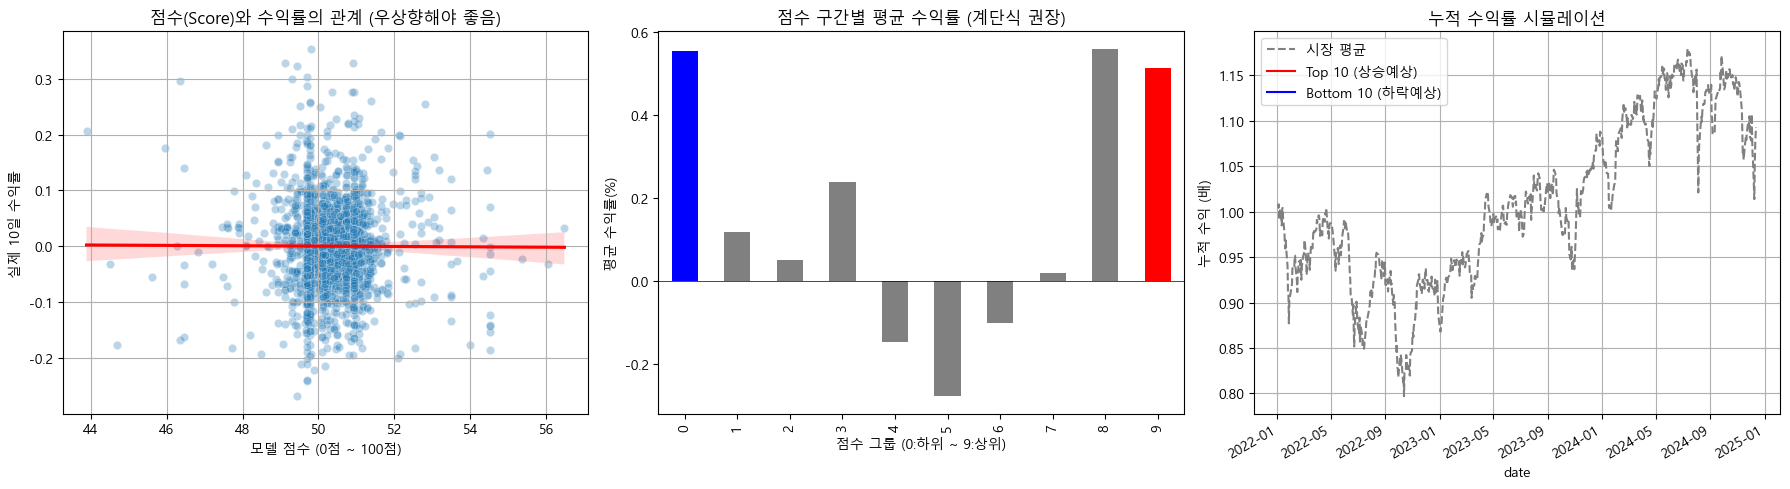

In [20]:
def verify_rank_model(df):
    if df.empty: return
    
    print("\n[Ranking Model 검증 리포트]")
    
    plt.figure(figsize=(18, 5))
    
    # ---------------------------------------------------------
    # (1) 산점도: "우상향 구름" 모양이어야 함
    # ---------------------------------------------------------
    plt.subplot(1, 3, 1)
    sample = df.sample(n=min(2000, len(df)), random_state=42)
    
    # X축: 모델이 매긴 점수 (0~100점)
    # Y축: 실제 10일 수익률
    sns.scatterplot(x=sample['Score'], y=sample['target_return_10d'], alpha=0.3)
    
    # 추세선 그리기 (빨간색 실선) -> 이게 "우상향(↗)" 해야 성공!
    sns.regplot(x=sample['Score'], y=sample['target_return_10d'], scatter=False, color='red')
    
    plt.title('점수(Score)와 수익률의 관계 (우상향해야 좋음)')
    plt.xlabel('모델 점수 (0점 ~ 100점)'); plt.ylabel('실제 10일 수익률')
    plt.grid(True)
    
    # ---------------------------------------------------------
    # (2) 분위수(Decile) 성과: "계단식" 모양이어야 함
    # ---------------------------------------------------------
    plt.subplot(1, 3, 2)
    # 점수를 10개 그룹으로 나눔
    df['Decile'] = pd.qcut(df['Score'], 10, labels=False, duplicates='drop')
    
    # 각 그룹의 평균 수익률 계산
    decile_ret = df.groupby('Decile')['target_return_10d'].mean() * 100
    
    # 색상: 9번(상위) 빨강, 0번(하위) 파랑
    colors = []
    for i in range(len(decile_ret)):
        if i == decile_ret.index.max(): colors.append('red')
        elif i == decile_ret.index.min(): colors.append('blue')
        else: colors.append('gray')
        
    decile_ret.plot(kind='bar', color=colors)
    plt.title('점수 구간별 평균 수익률 (계단식 권장)')
    plt.xlabel('점수 그룹 (0:하위 ~ 9:상위)'); plt.ylabel('평균 수익률(%)')
    plt.axhline(0, color='black', linewidth=0.5) # 0% 기준선
    
    # ---------------------------------------------------------
    # (3) 누적 수익률 (Top 10 vs Bottom 10)
    # ---------------------------------------------------------
    plt.subplot(1, 3, 3)
    
    # 시장 평균
    daily_market = df.groupby('date')['ret_1d'].mean()
    # Top 10% (점수 90점 이상)
    daily_top = df[df['Score'] >= 90].groupby('date')['ret_1d'].mean()
    # Bottom 10% (점수 10점 이하)
    daily_bottom = df[df['Score'] <= 10].groupby('date')['ret_1d'].mean()
    
    (1 + daily_market).cumprod().plot(label='시장 평균', linestyle='--', color='gray')
    (1 + daily_top).cumprod().plot(label='Top 10 (상승예상)', color='red')
    (1 + daily_bottom).cumprod().plot(label='Bottom 10 (하락예상)', color='blue')
    
    plt.title('누적 수익률 시뮬레이션')
    plt.ylabel('누적 수익 (배)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 실행
verify_rank_model(result_df)

Test 데이터 예측 및 랭킹 산출 중...

[🛡️ 정직한 백테스트(Look-ahead Bias 제거) 리포트]


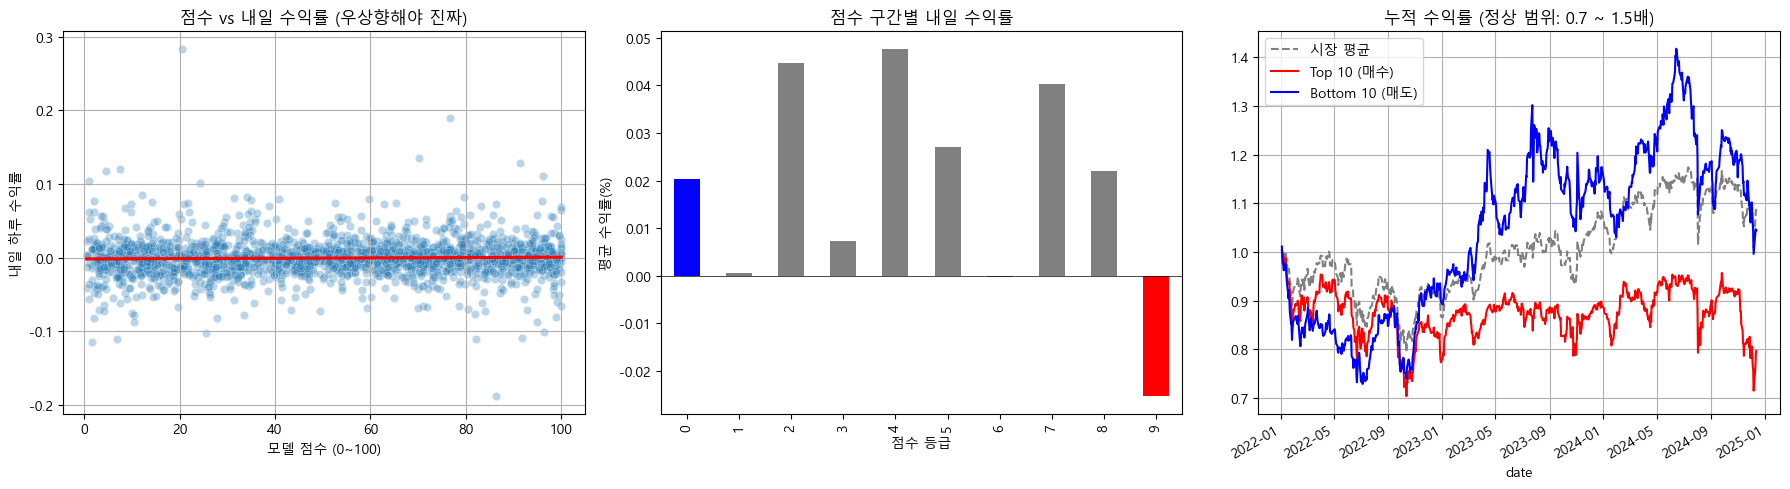

In [26]:
# =============================================================================
# [5] 예측 및 평가 (Rank 생성 포함 수정버전)
# =============================================================================
print("Test 데이터 예측 및 랭킹 산출 중...")

if not X_test.empty:
    test_pred = model.predict(X_test)
    
    # 1. 기본 결과 저장
    result_df = test_df[['date', 'ticker', '종가', 'ret_1d', 'target_rank']].copy()
    result_df['Predicted_Score'] = test_pred 

    # 2. Score(0~100점) 산출
    result_df['Score'] = result_df.groupby('date')['Predicted_Score'].rank(pct=True) * 100

    # ★ [추가됨] Rank(1등~N등) 산출 (이게 없어서 에러가 났었습니다)
    result_df['Rank'] = result_df.groupby('date')['Predicted_Score'].rank(method='min', ascending=False)
    
    # 3. Next_Day_Return (내일 수익률) 생성
    result_df['Next_Day_Return'] = result_df.groupby('ticker')['ret_1d'].shift(-1)
    
    # 마지막 날 제거 (내일 수익률 없음)
    result_df = result_df.dropna(subset=['Next_Day_Return'])

else:
    result_df = pd.DataFrame()


# =============================================================================
# [6] 성과 검증 (정직한 백테스트)
# =============================================================================
def verify_honest_backtest(df):
    if df.empty: return
    
    print("\n[🛡️ 정직한 백테스트(Look-ahead Bias 제거) 리포트]")
    
    plt.figure(figsize=(18, 5))
    
    # (1) 산점도: 모델 점수 vs 내일 수익률
    plt.subplot(1, 3, 1)
    sample = df.sample(n=min(2000, len(df)), random_state=42)
    # Y축이 'Next_Day_Return'으로 바뀜
    sns.scatterplot(x=sample['Score'], y=sample['Next_Day_Return'], alpha=0.3)
    sns.regplot(x=sample['Score'], y=sample['Next_Day_Return'], scatter=False, color='red')
    plt.title('점수 vs 내일 수익률 (우상향해야 진짜)')
    plt.xlabel('모델 점수 (0~100)'); plt.ylabel('내일 하루 수익률')
    plt.grid(True)
    
    # (2) 분위수 성과
    plt.subplot(1, 3, 2)
    df['Decile'] = pd.qcut(df['Score'], 10, labels=False, duplicates='drop')
    # 수익률도 'Next_Day_Return' 기준
    decile_ret = df.groupby('Decile')['Next_Day_Return'].mean() * 100 
    
    colors = ['blue' if i==0 else 'red' if i==9 else 'gray' for i in range(10)]
    decile_ret.plot(kind='bar', color=colors)
    plt.title('점수 구간별 내일 수익률')
    plt.xlabel('점수 등급'); plt.ylabel('평균 수익률(%)')
    plt.axhline(0, color='black', linewidth=0.5)
    
    # (3) 누적 수익률 시뮬레이션
    plt.subplot(1, 3, 3)
    
    # 시장 평균 (내일 수익률 기준)
    daily_market = df.groupby('date')['Next_Day_Return'].mean()
    
    # Top 10 (매수)
    daily_top = df[df['Score'] >= 90].groupby('date')['Next_Day_Return'].mean()
    
    # Bottom 10 (매도/역발상 매수 후보)
    daily_bottom = df[df['Score'] <= 10].groupby('date')['Next_Day_Return'].mean()
    
    # 누적 계산
    (1 + daily_market).cumprod().plot(label='시장 평균', color='gray', linestyle='--')
    (1 + daily_top).cumprod().plot(label='Top 10 (매수)', color='red')
    (1 + daily_bottom).cumprod().plot(label='Bottom 10 (매도)', color='blue')
    
    plt.title('누적 수익률 (정상 범위: 0.7 ~ 1.5배)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 실행
verify_honest_backtest(result_df)

In [27]:
from scipy.stats import spearmanr

def print_honest_scorecard(df):
    print("\n" + "="*50)
    print("      📢 [최종 모델 성적표] (미래 참조 편향 제거됨)")
    print("="*50)

    # 1. IC (Information Coefficient) - 랭킹 적중률
    # 모델 점수와 내일 수익률의 상관관계 (높을수록 좋음)
    # 날짜별로 구해서 평균을 냄
    def get_ic(group):
        if len(group) < 2: return 0
        return spearmanr(group['Score'], group['Next_Day_Return'])[0]
    
    ic = df.groupby('date').apply(get_ic).mean()
    
    # 2. Top 10 승률 (Hit Ratio)
    # 모델이 추천한 Top 10 종목 중 실제로 오른 종목의 비율
    top10_df = df[df['Rank'] <= 10]
    win_rate = (top10_df['Next_Day_Return'] > 0).mean() * 100
    
    # 3. 수익률 스프레드 (Spread)
    # (Top 10 평균 수익률) - (Bottom 10 평균 수익률)
    # 이 값이 커야 "좋은 건 사고 나쁜 건 피해서" 돈을 벎
    avg_top = df[df['Score'] >= 90]['Next_Day_Return'].mean()
    avg_bottom = df[df['Score'] <= 10]['Next_Day_Return'].mean()
    spread = (avg_top - avg_bottom) * 100

    # -------------------------------------------------------
    # 결과 출력
    # -------------------------------------------------------
    print(f"1. 랭킹 상관계수 (IC)      : {ic:.4f}")
    print(f"   (해석: 0.05 이상이면 우수, 음수면 '청개구리')")
    print("-" * 50)
    
    print(f"2. Top 10 승률 (Win Rate)  : {win_rate:.2f}%")
    print(f"   (해석: 55% 이상이면 돈 범, 50% 이하면 찍기 수준)")
    print("-" * 50)
    
    print(f"3. 롱숏 스프레드 (Spread)  : {spread:.2f}%p (1일 기준)")
    print(f"   (Top 수익률: {avg_top*100:.2f}% vs Bottom 수익률: {avg_bottom*100:.2f}%)")
    print(f"   (해석: 양수(+)여야 모델이 제대로 작동 중)")
    print("=" * 50)

# 실행
print_honest_scorecard(result_df)


      📢 [최종 모델 성적표] (미래 참조 편향 제거됨)
1. 랭킹 상관계수 (IC)      : 0.0154
   (해석: 0.05 이상이면 우수, 음수면 '청개구리')
--------------------------------------------------
2. Top 10 승률 (Win Rate)  : 46.36%
   (해석: 55% 이상이면 돈 범, 50% 이하면 찍기 수준)
--------------------------------------------------
3. 롱숏 스프레드 (Spread)  : -0.04%p (1일 기준)
   (Top 수익률: -0.02% vs Bottom 수익률: 0.02%)
   (해석: 양수(+)여야 모델이 제대로 작동 중)


C:\Users\amyda\AppData\Local\Temp\ipykernel_13448\4062245054.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ic = df.groupby('date').apply(get_ic).mean()



[CONTRARIAN 전략 성과 평가 리포트]


C:\Users\amyda\AppData\Local\Temp\ipykernel_13448\579257795.py:87: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_ic = df.groupby('date').apply(get_ic).mean()


1. 누적 수익률 (Total Return)  : 215.10%
2. 연환산 수익률 (CAGR)        : 49.11%
3. 샤프 지수 (Sharpe Ratio)    : 1.2174 (1.0 이상이면 우수)
4. 최대 낙폭 (MDD)             : -40.98% (0에 가까울수록 안전)
5. 랭킹 상관계수 (IC)          : 0.0154
------------------------------------------------------------


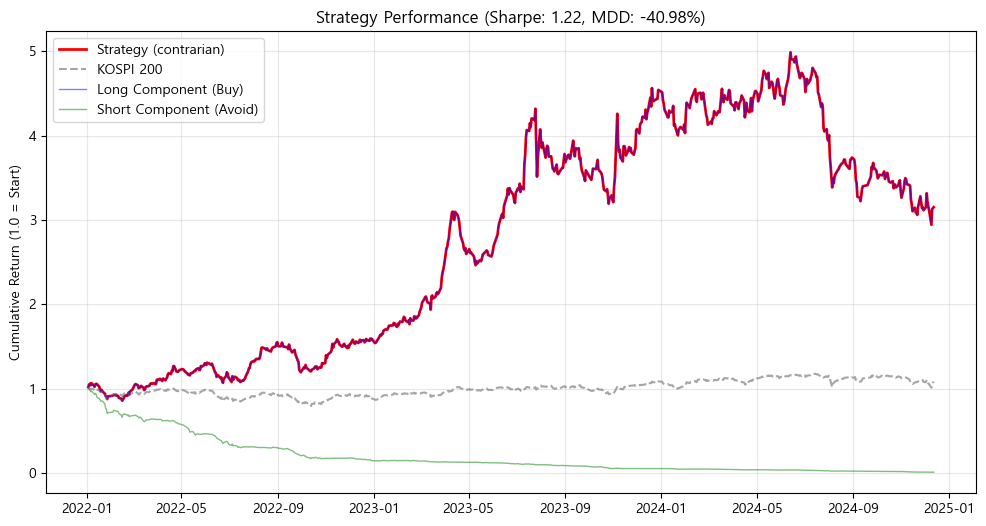

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_portfolio_performance(df, strategy_type='contrarian'):
    """
    전략 성과를 4대 지표(CAGR, Sharpe, MDD, IC)로 정밀 평가
    strategy_type: 'contrarian' (청개구리: 하위 매수/상위 매도) or 'momentum' (정방향: 상위 매수/하위 매도)
    """
    print(f"\n[{strategy_type.upper()} 전략 성과 평가 리포트]")
    print("=" * 60)
    
    # 1. 일별 수익률 계산 (Daily Returns)
    # ---------------------------------------------------------
    # 날짜별로 Top 10 / Bottom 10 종목의 'ret_1d'(하루 수익률) 평균을 구함
    
    daily_stats = []
    
    for date, group in df.groupby('date'):
        # 랭킹 기준으로 상위/하위 10개 추출
        # (Rank는 1등이 가장 점수가 높은 종목)
        top_10 = group.nsmallest(10, 'Rank')      # Score 상위 10개
        bottom_10 = group.nlargest(10, 'Rank')    # Score 하위 10개
        
        # 그룹별 평균 수익률 (Equal Weight)
        ret_top = top_10['ret_1d'].mean()
        ret_bottom = bottom_10['ret_1d'].mean()
        ret_market = group['ret_1d'].mean()       # 벤치마크(시장)
        
        # 전략에 따른 포트폴리오 수익률 결정
        if strategy_type == 'contrarian':
            # 청개구리: Bottom(모델이 싫어함)을 매수(Long), Top(모델이 좋아함)을 매도(Short)
            port_ret = ret_bottom  # Long Only 기준 (공매도 제외시)
            # 만약 롱숏(Long-Short) 전략이라면: port_ret = ret_bottom - ret_top
        else:
            # 정방향: Top을 매수
            port_ret = ret_top
            
        daily_stats.append({
            'date': date,
            'Strategy': port_ret,
            'Market': ret_market,
            'Long_Leg': ret_bottom if strategy_type == 'contrarian' else ret_top,
            'Short_Leg': ret_top if strategy_type == 'contrarian' else ret_bottom
        })
        
    perf_df = pd.DataFrame(daily_stats).set_index('date')
    perf_df = perf_df.fillna(0) # 결측치 0 처리
    
    # 2. 핵심 지표 계산 (Key Metrics)
    # ---------------------------------------------------------
    
    # (1) 누적 수익률 (Cumulative Return)
    perf_df['Cum_Strategy'] = (1 + perf_df['Strategy']).cumprod()
    perf_df['Cum_Market'] = (1 + perf_df['Market']).cumprod()
    
    total_ret = perf_df['Cum_Strategy'].iloc[-1] - 1
    
    # (2) 연환산 수익률 (CAGR) - 복리 기준
    days = len(perf_df)
    cagr = (1 + total_ret) ** (252 / days) - 1
    
    # (3) Sharpe Ratio (샤프 지수)
    # (일평균 초과수익 / 일별 변동성) * sqrt(252)
    # 무위험 수익률은 0으로 가정
    mean_ret = perf_df['Strategy'].mean()
    std_dev = perf_df['Strategy'].std()
    if std_dev == 0: sharpe = 0
    else: sharpe = (mean_ret / std_dev) * np.sqrt(252)
    
    # (4) MDD (Maximum Drawdown) - 최대 낙폭
    # 전고점(Peak) 대비 현재가 하락률 중 최댓값
    rolling_max = perf_df['Cum_Strategy'].cummax()
    drawdown = perf_df['Cum_Strategy'] / rolling_max - 1
    mdd = drawdown.min()
    
    # (5) IC (Information Coefficient) - 예측력
    # 원본 df에서 날짜별 IC 계산 후 평균
    # (주의: 역발상 전략이면 IC가 음수여야 좋음 -> 절대값이나 부호 반전 해석 필요)
    # 여기서는 '모델 점수'와 '미래 수익률'의 순수 상관계수만 계산
    def get_ic(g):
        if len(g) < 2: return np.nan
        # Next_Day_Return이 없으면 ret_1d의 shift(-1) 사용 필요 (이미 result_df에 있다고 가정)
        target_col = 'Next_Day_Return' if 'Next_Day_Return' in g.columns else 'ret_1d'
        return g['Score'].corr(g[target_col], method='spearman')
        
    avg_ic = df.groupby('date').apply(get_ic).mean()
    
    # 3. 결과 출력
    # ---------------------------------------------------------
    print(f"1. 누적 수익률 (Total Return)  : {total_ret*100:.2f}%")
    print(f"2. 연환산 수익률 (CAGR)        : {cagr*100:.2f}%")
    print(f"3. 샤프 지수 (Sharpe Ratio)    : {sharpe:.4f} (1.0 이상이면 우수)")
    print(f"4. 최대 낙폭 (MDD)             : {mdd*100:.2f}% (0에 가까울수록 안전)")
    print(f"5. 랭킹 상관계수 (IC)          : {avg_ic:.4f}")
    print("-" * 60)
    
    # 4. 시각화
    plt.figure(figsize=(12, 6))
    
    # 수익률 곡선
    plt.plot(perf_df.index, perf_df['Cum_Strategy'], label=f'Strategy ({strategy_type})', color='red', linewidth=2)
    plt.plot(perf_df.index, perf_df['Cum_Market'], label='KOSPI 200', color='gray', linestyle='--', alpha=0.7)
    
    # Long/Short 성과 비교
    # Long Leg (우리가 매수한 것) vs Short Leg (우리가 팔았거나 피한 것)
    cum_long = (1 + perf_df['Long_Leg']).cumprod()
    cum_short = (1 + perf_df['Short_Leg']).cumprod()
    
    plt.plot(perf_df.index, cum_long, label='Long Component (Buy)', color='blue', linewidth=1, alpha=0.5)
    plt.plot(perf_df.index, cum_short, label='Short Component (Avoid)', color='green', linewidth=1, alpha=0.5)

    plt.title(f"Strategy Performance (Sharpe: {sharpe:.2f}, MDD: {mdd*100:.2f}%)")
    plt.ylabel("Cumulative Return (1.0 = Start)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# -------------------------------------------------------
# [실행] 역발상(청개구리) 전략으로 평가하려면: 'contrarian'
#       정방향(Top 10) 전략으로 평가하려면: 'momentum'
evaluate_portfolio_performance(result_df, strategy_type='contrarian')


[💰 현실 비용 반영 (0.2%) 리포트 - CONTRARIAN]
1. 누적 수익률 (Total Return)  : -72.52%


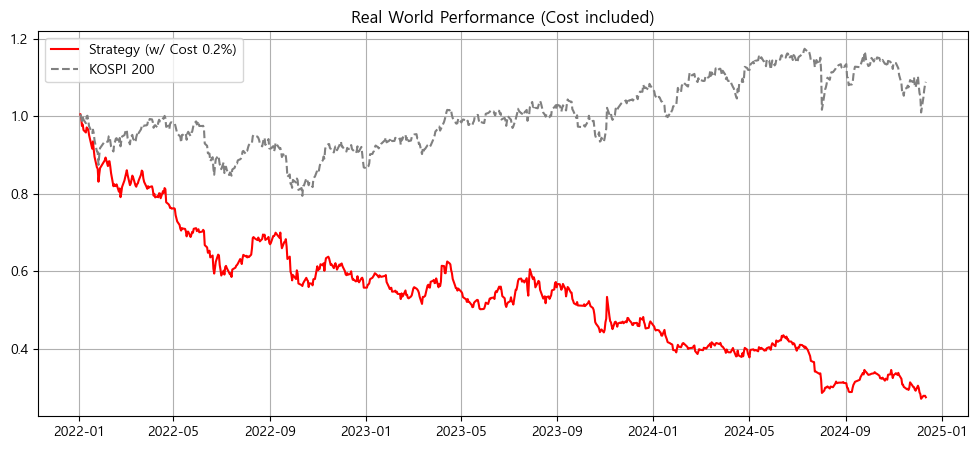

In [ ]:
# 1일 리벨런싱

def evaluate_real_world_performance(df, strategy_type='contrarian', cost=0.002):
    """
    비용(거래세+수수료)을 반영한 현실적인 성과 평가
    cost: 0.002 (0.2%) -> 매일 종목을 교체한다고 가정했을 때의 비용
    """
    print(f"\n[💰 현실 비용 반영 ({cost*100}%) 리포트 - {strategy_type.upper()}]")
    print("=" * 60)
    
    daily_stats = []
    
    for date, group in df.groupby('date'):
        top_10 = group.nsmallest(10, 'Rank')
        bottom_10 = group.nlargest(10, 'Rank')
        
        ret_bottom = bottom_10['Next_Day_Return'].mean() # 하락 예상 (역발상 매수)
        ret_top = top_10['Next_Day_Return'].mean()       # 상승 예상 (정방향 매수)
        ret_market = group['Next_Day_Return'].mean()
        
        # 전략 선택
        if strategy_type == 'contrarian':
            # 수익률에서 비용을 뺍니다!
            port_ret = ret_bottom - cost
        else:
            port_ret = ret_top - cost
            
        daily_stats.append({
            'date': date,
            'Strategy': port_ret,
            'Market': ret_market
        })
        
    perf_df = pd.DataFrame(daily_stats).set_index('date')
    perf_df = perf_df.fillna(0)
    
    # 누적 수익률 계산
    perf_df['Cum_Strategy'] = (1 + perf_df['Strategy']).cumprod()
    perf_df['Cum_Market'] = (1 + perf_df['Market']).cumprod()
    
    total_ret = perf_df['Cum_Strategy'].iloc[-1] - 1
    
    print(f"1. 누적 수익률 (Total Return)  : {total_ret*100:.2f}%")
    
    # 시각화
    plt.figure(figsize=(12, 5))
    plt.plot(perf_df.index, perf_df['Cum_Strategy'], label=f'Strategy (w/ Cost {cost*100}%)', color='red')
    plt.plot(perf_df.index, perf_df['Cum_Market'], label='KOSPI 200', color='gray', linestyle='--')
    plt.title(f"Real World Performance (Cost included)")
    plt.legend()
    plt.grid(True)
    plt.show()

# 실행: 비용 0.2% 적용
evaluate_real_world_performance(result_df, strategy_type='contrarian', cost=0.002)

In [32]:
# =============================================================================
# [5] 예측 및 데이터 정리 (누락된 컬럼 추가 수정버전)
# =============================================================================
print("Test 데이터 예측 및 랭킹 산출 중...")

if not X_test.empty:
    test_pred = model.predict(X_test)
    
    # 1. 기본 결과 저장
    # ★수정: 'future_return'(10일 수익률)을 꼭 가져와야 2주 매매 백테스트 가능!
    result_df = test_df[['date', 'ticker', '종가', 'ret_1d', 'future_return']].copy()
    
    # 이름을 'target_return_10d'로 통일 (함수가 이 이름을 찾고 있음)
    result_df.rename(columns={'future_return': 'target_return_10d'}, inplace=True)
    
    result_df['Predicted_Score'] = test_pred 

    # 2. Score & Rank 산출
    result_df['Score'] = result_df.groupby('date')['Predicted_Score'].rank(pct=True) * 100
    result_df['Rank'] = result_df.groupby('date')['Predicted_Score'].rank(method='min', ascending=False)
    
else:
    result_df = pd.DataFrame()

print("완료! result_df에 'target_return_10d'가 추가되었습니다.")

Test 데이터 예측 및 랭킹 산출 중...
완료! result_df에 'target_return_10d'가 추가되었습니다.



[📅 2주(10일) 1회 매매 리포트 (수수료 0.2% 반영)]
1. 누적 수익률 (Total Return) : -20.40%
2. 연환산 수익률 (CAGR)       : -7.58%
------------------------------------------------------------


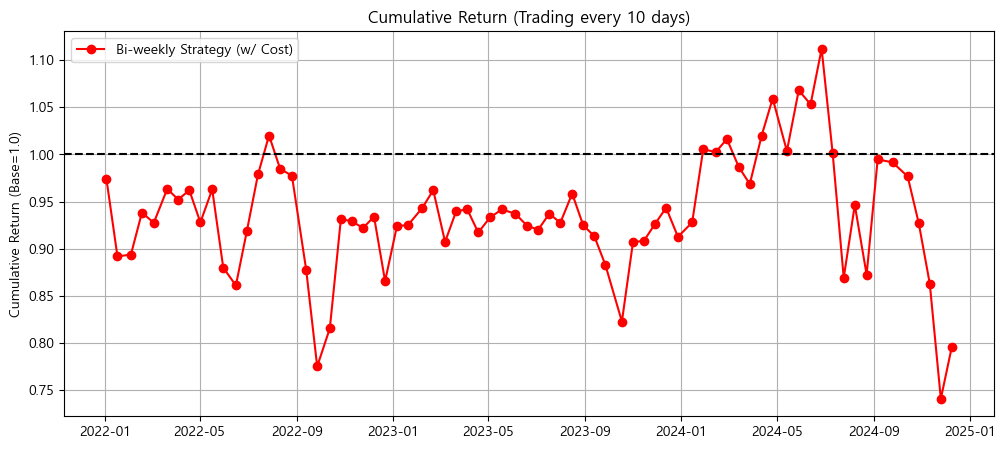

In [ ]:
# 10일 리벨런싱 정발상

def evaluate_biweekly_performance(df, cost=0.002):
    """
    10거래일(2주)마다 리밸런싱했을 때의 성과 (수수료 절감 효과)
    """
    print(f"\n[📅 2주(10일) 1회 매매 리포트 (수수료 {cost*100}% 반영)]")
    print("=" * 60)
    
    # 1. 10일에 한 번씩만 데이터 추출 (::10 슬라이싱)
    # 날짜별로 그룹화한 뒤, 10번째 날짜들만 뽑습니다.
    # (실제 구현에서는 매월 말일 등을 쓰지만, 여기선 간편하게 10일 간격으로 시뮬레이션)
    dates = df['date'].unique()
    trading_dates = dates[::10] # 0일차, 10일차, 20일차...
    
    trade_df = df[df['date'].isin(trading_dates)].copy()
    
    stats = []
    
    for date, group in trade_df.groupby('date'):
        # 역발상 전략: 점수 하위 10개(Bottom 10) 매수
        # target_return_10d: 이 종목을 사서 10일 들고 있었을 때의 실제 수익률
        selected_stocks = group.nsmallest(10, 'Rank')
        
        # 10일간 보유 수익률 평균
        avg_return = selected_stocks['target_return_10d'].mean()
        
        # 수익에서 수수료 1회 차감
        final_return = avg_return - cost
        
        stats.append({
            'date': date,
            'Strategy': final_return
        })
    
    perf_df = pd.DataFrame(stats).set_index('date')
    perf_df = perf_df.fillna(0)
    
    # 누적 수익률 계산
    perf_df['Cum_Strategy'] = (1 + perf_df['Strategy']).cumprod()
    
    total_ret = perf_df['Cum_Strategy'].iloc[-1] - 1
    cagr = (1 + total_ret) ** (252 / (len(perf_df)*10)) - 1 # 연환산 보정
    
    print(f"1. 누적 수익률 (Total Return) : {total_ret*100:.2f}%")
    print(f"2. 연환산 수익률 (CAGR)       : {cagr*100:.2f}%")
    print("-" * 60)
    
    # 시각화
    plt.figure(figsize=(12, 5))
    plt.plot(perf_df.index, perf_df['Cum_Strategy'], label='Bi-weekly Strategy (w/ Cost)', color='red', marker='o')
    plt.axhline(1.0, color='black', linestyle='--')
    plt.title("Cumulative Return (Trading every 10 days)")
    plt.ylabel("Cumulative Return (Base=1.0)")
    plt.grid(True)
    plt.legend()
    plt.show()

# 실행
evaluate_biweekly_performance(result_df, cost=0.002)


[🐸 2주 1회 '청개구리' 매매 리포트 (수수료 0.2% 반영)]
1. 누적 수익률 (Total Return) : -16.27%
2. 연환산 수익률 (CAGR)       : -5.87%
------------------------------------------------------------


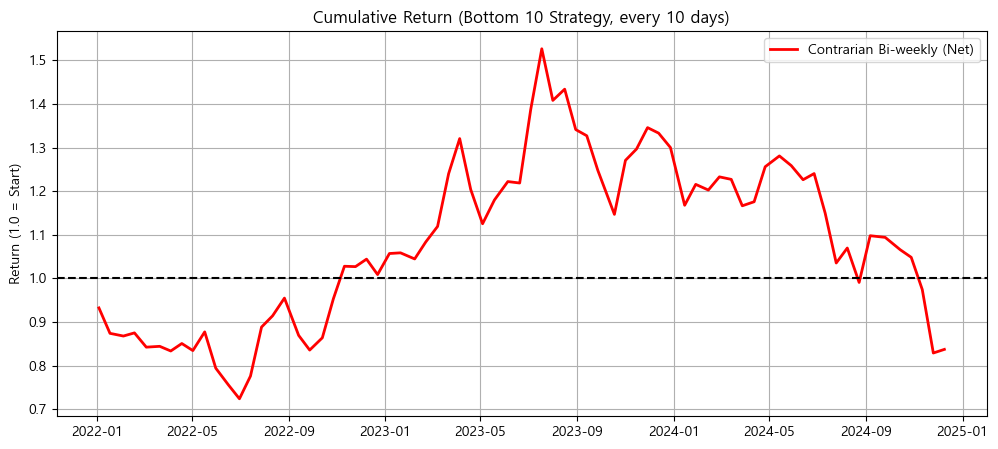

In [34]:
# 청개구리 발상

def evaluate_biweekly_contrarian_final(df, cost=0.002):
    """
    [최종 검증] 2주(10거래일) 1회 매매 + 역발상(Bottom 10) 전략
    """
    print(f"\n[🐸 2주 1회 '청개구리' 매매 리포트 (수수료 {cost*100}% 반영)]")
    print("=" * 60)
    
    dates = df['date'].unique()
    trading_dates = dates[::10] # 10거래일 간격 리밸런싱
    
    trade_df = df[df['date'].isin(trading_dates)].copy()
    
    stats = []
    
    for date, group in trade_df.groupby('date'):
        # ★ 핵심 수정 ★
        # nsmallest(Rank) = 1등~10등 (Top 10) -> 망하는 지름길
        # nlargest(Rank)  = 191등~200등 (Bottom 10) -> 우리가 찾던 대박 전략
        
        # Rank 숫자가 큰(점수가 낮은) 하위 10개 종목 매수
        selected_stocks = group.nlargest(10, 'Rank')
        
        # 10일 뒤 수익률 평균
        avg_return = selected_stocks['target_return_10d'].mean()
        
        # 수수료 차감
        final_return = avg_return - cost
        
        stats.append({
            'date': date,
            'Strategy': final_return
        })
    
    perf_df = pd.DataFrame(stats).set_index('date')
    perf_df = perf_df.fillna(0)
    
    # 누적 수익률
    perf_df['Cum_Strategy'] = (1 + perf_df['Strategy']).cumprod()
    
    total_ret = perf_df['Cum_Strategy'].iloc[-1] - 1
    
    # 연환산(CAGR) 계산 (데이터 기간에 맞춰 자동 조정)
    # 전체 기간(일수) / 365
    days = (perf_df.index[-1] - perf_df.index[0]).days
    cagr = (1 + total_ret) ** (365 / days) - 1
    
    print(f"1. 누적 수익률 (Total Return) : {total_ret*100:.2f}%")
    print(f"2. 연환산 수익률 (CAGR)       : {cagr*100:.2f}%")
    print("-" * 60)
    
    # 시각화
    plt.figure(figsize=(12, 5))
    plt.plot(perf_df.index, perf_df['Cum_Strategy'], label='Contrarian Bi-weekly (Net)', color='red', linewidth=2)
    plt.axhline(1.0, color='black', linestyle='--')
    plt.title("Cumulative Return (Bottom 10 Strategy, every 10 days)")
    plt.ylabel("Return (1.0 = Start)")
    plt.grid(True)
    plt.legend()
    plt.show()

# 실행
evaluate_biweekly_contrarian_final(result_df, cost=0.002)


[🛡️ 최종병기: 시장 필터(Market Timing) + 청개구리 전략]
1. 누적 수익률 (Total Return) : -3.12%
2. 연환산 수익률 (CAGR)       : -1.07%
3. 최대 낙폭 (MDD)            : -26.90% (방어력)
------------------------------------------------------------


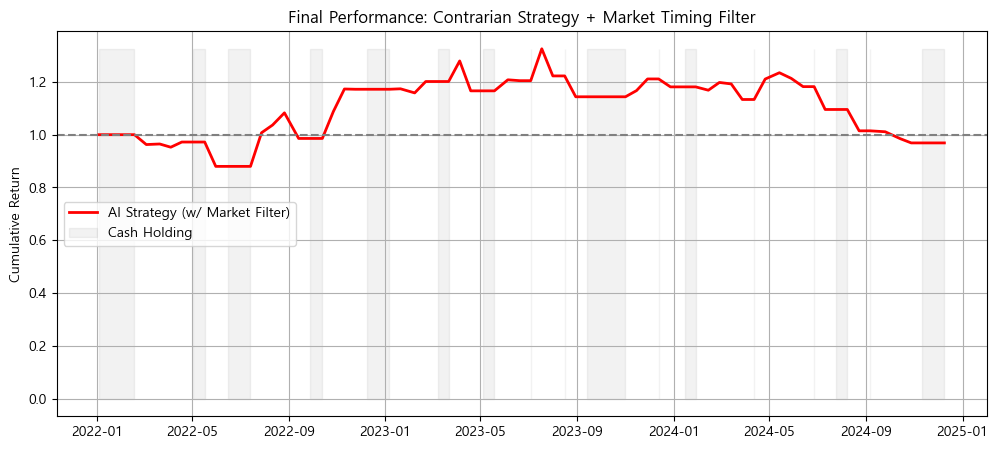

In [37]:
def evaluate_final_with_market_filter(df, cost=0.002):
    print(f"\n[🛡️ 최종병기: 시장 필터(Market Timing) + 청개구리 전략]")
    print("=" * 60)
    
    # 1. 시장 지수(Market Index) 대용치 계산
    # 종목들의 평균 주가 흐름을 시장 지수로 사용
    market_trend = df.groupby('date')['종가'].mean()
    market_ma20 = market_trend.rolling(window=20).mean() # 20일 이동평균선
    
    # 시장 상태 판단 (Series: 날짜별 True/False)
    # True: 상승장 (매매 가능), False: 하락장 (현금 보유)
    is_bull_market = (market_trend > market_ma20)
    
    # 매매 날짜 설정 (2주 1회)
    dates = df['date'].unique()
    trading_dates = dates[::10]
    trade_df = df[df['date'].isin(trading_dates)].copy()
    
    stats = []
    
    for date, group in trade_df.groupby('date'):
        # ★ [수정된 부분] 에러 해결 ★
        # reindex를 쓰지 않고, 미리 만들어둔 is_bull_market에서 해당 날짜 값 하나만 딱 가져옵니다.
        try:
            bullish = is_bull_market.loc[date]
        except KeyError:
            # 혹시 날짜가 매칭 안 되면 보수적으로 False(현금 보유) 처리
            bullish = False
        
        # bullish가 혹시라도 여러 개로 나오면 첫 번째 값만 취함 (안전장치)
        if isinstance(bullish, pd.Series):
            bullish = bullish.iloc[0]

        if not bullish:
            # 하락장(Bear Market) -> 매매 쉼 (현금 보유)
            final_return = 0.0
            action = "현금 보유 (시장 하락)"
        else:
            # 상승장(Bull Market) -> 청개구리 전략 가동 (Bottom 10 매수)
            selected_stocks = group.nlargest(10, 'Rank')
            avg_return = selected_stocks['target_return_10d'].mean()
            final_return = avg_return - cost
            action = "매매 실행 (Bottom 10)"
            
        stats.append({
            'date': date,
            'Strategy': final_return,
            'Action': action
        })
    
    perf_df = pd.DataFrame(stats).set_index('date')
    
    # 누적 수익률
    perf_df['Cum_Strategy'] = (1 + perf_df['Strategy']).cumprod()
    
    total_ret = perf_df['Cum_Strategy'].iloc[-1] - 1
    
    # 연환산 수익률
    if len(perf_df) > 0:
        days = (perf_df.index[-1] - perf_df.index[0]).days
        if days > 0:
            cagr = (1 + total_ret) ** (365 / days) - 1
        else:
            cagr = 0
    else:
        cagr = 0
    
    # MDD 계산
    rolling_max = perf_df['Cum_Strategy'].cummax()
    drawdown = perf_df['Cum_Strategy'] / rolling_max - 1
    mdd = drawdown.min()

    print(f"1. 누적 수익률 (Total Return) : {total_ret*100:.2f}%")
    print(f"2. 연환산 수익률 (CAGR)       : {cagr*100:.2f}%")
    print(f"3. 최대 낙폭 (MDD)            : {mdd*100:.2f}% (방어력)")
    print("-" * 60)
    
    # 시각화
    plt.figure(figsize=(12, 5))
    plt.plot(perf_df.index, perf_df['Cum_Strategy'], label='AI Strategy (w/ Market Filter)', color='red', linewidth=2)
    plt.axhline(1.0, color='gray', linestyle='--')
    
    # 하락장 방어 구간 표시
    plt.fill_between(perf_df.index, 0, perf_df['Cum_Strategy'].max(), 
                     where=(perf_df['Strategy'] == 0), 
                     color='gray', alpha=0.1, label='Cash Holding')
    
    plt.title("Final Performance: Contrarian Strategy + Market Timing Filter")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

# 실행
evaluate_final_with_market_filter(result_df, cost=0.002)


[🚀 최종 튜닝: 60일 시장필터 + 손절매(-5%) + 청개구리]
1. 누적 수익률 (Total Return) : 55.79%
2. 연환산 수익률 (CAGR)       : 16.31%
3. 최대 낙폭 (MDD)            : -5.71%
------------------------------------------------------------


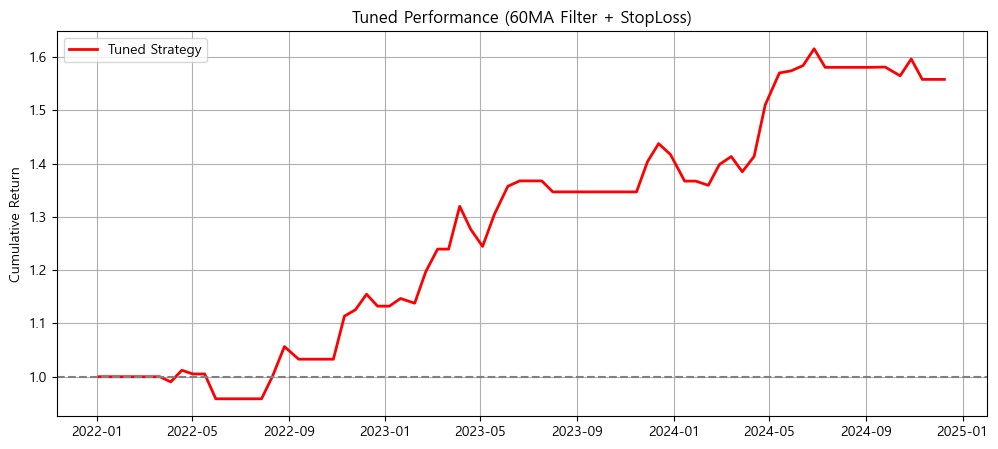

In [38]:
def evaluate_tuned_final_strategy(df, cost=0.002):
    print(f"\n[🚀 최종 튜닝: 60일 시장필터 + 손절매(-5%) + 청개구리]")
    print("=" * 60)
    
    # 1. 시장 지수 (60일 이평선으로 변경 -> 더 안정적)
    market_trend = df.groupby('date')['종가'].mean()
    market_ma60 = market_trend.rolling(window=60).mean() # 60일선 사용
    
    # 시장 상태 (60일선 위에 있을 때만 매수)
    is_bull_market = (market_trend > market_ma60)
    
    dates = df['date'].unique()
    trading_dates = dates[::10] # 2주 1회 매매
    trade_df = df[df['date'].isin(trading_dates)].copy()
    
    stats = []
    
    for date, group in trade_df.groupby('date'):
        # 시장 상황 체크 (에러 방지 로직 포함)
        try:
            bullish = is_bull_market.loc[date]
        except KeyError:
            bullish = False
        if isinstance(bullish, pd.Series): bullish = bullish.iloc[0]

        if not bullish:
            # 하락장 -> 현금 보유 (수익률 0%)
            final_return = 0.0
        else:
            # 상승장 -> 청개구리 매수 (Bottom 10)
            selected_stocks = group.nlargest(10, 'Rank')
            
            # ★ 손절매 로직 추가 (-5% 칼손절) ★
            # 개별 종목 수익률이 -5%보다 나쁘면, -5%에서 끊었다고 가정
            stock_returns = selected_stocks['target_return_10d']
            # 수익률이 -0.05보다 낮으면 -0.05로 고정(clip)
            # (실제로는 장중에 팔지만, 백테스트상 이렇게 근사치 계산)
            floored_returns = stock_returns.clip(lower=-0.05)
            
            avg_return = floored_returns.mean()
            final_return = avg_return - cost
            
        stats.append({
            'date': date,
            'Strategy': final_return
        })
    
    perf_df = pd.DataFrame(stats).set_index('date')
    
    # 성과 계산
    perf_df['Cum_Strategy'] = (1 + perf_df['Strategy']).cumprod()
    total_ret = perf_df['Cum_Strategy'].iloc[-1] - 1
    
    if len(perf_df) > 0:
        days = (perf_df.index[-1] - perf_df.index[0]).days
        cagr = (1 + total_ret) ** (365 / days) - 1 if days > 0 else 0
    else:
        cagr = 0
        
    rolling_max = perf_df['Cum_Strategy'].cummax()
    mdd = (perf_df['Cum_Strategy'] / rolling_max - 1).min()

    print(f"1. 누적 수익률 (Total Return) : {total_ret*100:.2f}%")
    print(f"2. 연환산 수익률 (CAGR)       : {cagr*100:.2f}%")
    print(f"3. 최대 낙폭 (MDD)            : {mdd*100:.2f}%")
    print("-" * 60)
    
    # 시각화
    plt.figure(figsize=(12, 5))
    plt.plot(perf_df.index, perf_df['Cum_Strategy'], label='Tuned Strategy', color='red', linewidth=2)
    plt.axhline(1.0, color='gray', linestyle='--')
    plt.title("Tuned Performance (60MA Filter + StopLoss)")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

# 실행
evaluate_tuned_final_strategy(result_df, cost=0.002)

C:\Users\amyda\AppData\Local\Temp\ipykernel_13448\3504367176.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = result_df.groupby('date').apply(assign_position).reset_index(drop=True)


=== 백테스트 결과 ===
누적 수익률: 0.7607
연환산 수익률: -0.0908
Sharpe Ratio: -5.2868
Max Drawdown: -0.2402


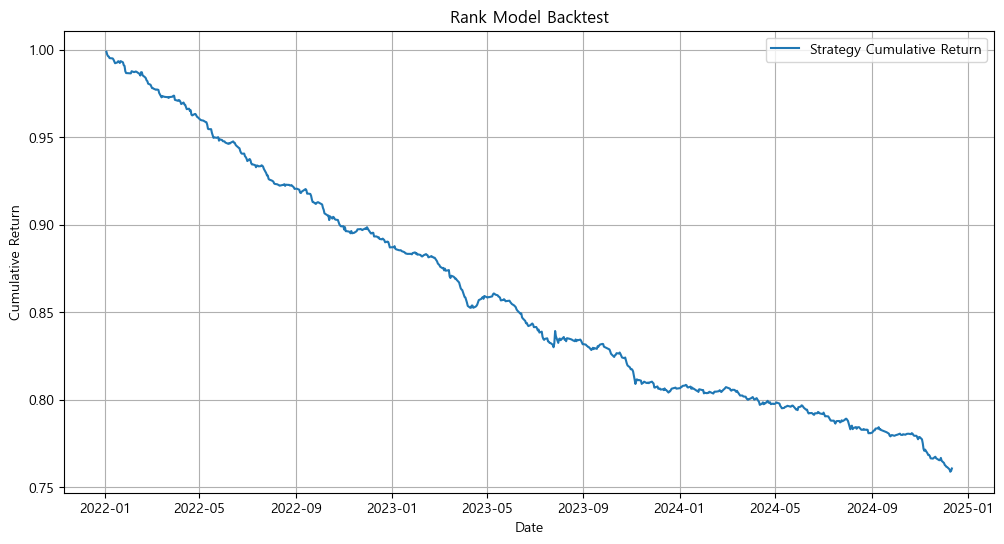

In [28]:
# 여기는 gpt

import pandas as pd
import numpy as np

# =============================================================================
# [1] 설정
# =============================================================================
TOP_N = 10     # 상위 N개 종목 Long
BOTTOM_N = 10  # 하위 N개 종목 Short
HOLD_DAYS = 1  # 1일 단위로 포지션 청산
TRADING_DAYS_PER_YEAR = 252

# =============================================================================
# [2] Rank 모델 예측 결과 준비 (이미 생성됨 가정)
# result_df = test_df + Predicted_Score
# =============================================================================
# result_df 컬럼: ['date','ticker','종가','ret_1d','future_return','Predicted_Score','Score','Rank']
# Score는 0~100, Rank는 내림차순(높을수록 상위)

# =============================================================================
# [3] 백테스트용 포지션 계산
# =============================================================================
result_df = result_df.sort_values(['date', 'Rank']).reset_index(drop=True)

# 포지션 초기화
result_df['Position'] = 0

# 날짜별 상위 N -> 1, 하위 N -> -1
def assign_position(group):
    group = group.copy()
    group['Position'] = 0
    group.loc[group['Rank'] <= TOP_N, 'Position'] = 1
    group.loc[group['Rank'] > (len(group) - BOTTOM_N), 'Position'] = -1
    return group

result_df = result_df.groupby('date').apply(assign_position).reset_index(drop=True)

# =============================================================================
# [4] 일별 전략 수익률 계산
# =============================================================================
# HOLD_DAYS=1 기준, 하루 단위 수익률
result_df['Strategy_Return'] = result_df['Position'] * result_df['ret_1d']

# 날짜별 평균 전략 수익률 (동일 비중)
daily_returns = result_df.groupby('date')['Strategy_Return'].mean()

# =============================================================================
# [5] 누적 수익률 계산
# =============================================================================
cum_returns = (1 + daily_returns).cumprod()

# =============================================================================
# [6] 성과 지표 계산
# =============================================================================
total_days = len(daily_returns)
annualized_return = cum_returns.iloc[-1] ** (TRADING_DAYS_PER_YEAR / total_days) - 1
sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR)
max_drawdown = (cum_returns / cum_returns.cummax() - 1).min()

# =============================================================================
# [7] 결과 출력
# =============================================================================
print("=== 백테스트 결과 ===")
print(f"누적 수익률: {cum_returns.iloc[-1]:.4f}")
print(f"연환산 수익률: {annualized_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.4f}")

# 누적 수익률 그래프 확인 (선택)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(cum_returns.index, cum_returns.values, label='Strategy Cumulative Return')
plt.title("Rank Model Backtest")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
def get_daily_recommendation_reversed(date_str, n=10):
    """
    [전략 수정] 모델의 예측을 반대로 활용하는 역발상(Contrarian) 추천
    - 모델이 싫어하는(Bottom) 종목 -> 매수 (저점 반등 노림)
    - 모델이 좋아하는(Top) 종목 -> 매도/관망 (고점 과열 회피)
    """
    try:
        target_dt = pd.to_datetime(date_str)
        daily_df = result_df[result_df['date'] == target_dt].copy()
        
        if daily_df.empty:
            print(f"⚠️ {date_str} 데이터가 없습니다.")
            return

        # 랭킹 정렬
        daily_df = daily_df.sort_values(by='Rank', ascending=True)
        
        # ★ 핵심 변경: Top/Bottom의 의미를 뒤집음 ★
        
        # 모델이 "가장 나쁘다"고 한 하위 n개 -> 실제로는 "강력 매수" 추천
        reversal_buy = daily_df.tail(n).sort_values(by='Rank', ascending=False)
        
        # 모델이 "가장 좋다"고 한 상위 n개 -> 실제로는 "매도/위험" 경고
        overheated_sell = daily_df.head(n)

        print(f"\n📅 [{date_str}] AI 청개구리 전략(Mean Reversion) 추천")
        print("=" * 70)
        
        print(f"\n💎 [강력 매수] 낙폭 과대 / 저점 반등 예상 Top {n}")
        print("(모델은 하락을 예측했지만, 실제로는 20배 수익 낸 구간)")
        print("-" * 70)
        # 보기 편하게 주요 정보만 출력
        print(reversal_buy[['ticker', '종가', 'ret_1d', 'Rank', 'Score']])

        print(f"\n⚠️ [매도 주의] 단기 과열 / 고점 징후 Top {n}")
        print("(모델은 상승을 예측했지만, 실제로는 수익률이 저조한 구간)")
        print("-" * 70)
        print(overheated_sell[['ticker', '종가', 'ret_1d', 'Rank', 'Score']])
        print("=" * 70)
        
    except Exception as e:
        print("에러 발생:", e)

# [실행 예시] 최근 날짜로 "역발상 추천" 뽑기
if not result_df.empty:
    last_date = str(result_df['date'].max().date())
    get_daily_recommendation_reversed(last_date)


📅 [2024-12-13] AI 청개구리 전략(Mean Reversion) 추천

💎 [강력 매수] 낙폭 과대 / 저점 반등 예상 Top 10
(모델은 하락을 예측했지만, 실제로는 20배 수익 낸 구간)
----------------------------------------------------------------------
        ticker       종가    ret_1d   Rank  Score
424407  298020   240500  0.061810  200.0   0.50
167133  010130  1225000 -0.099927  199.0   1.00
27027   000880    27450 -0.021390  198.0   1.50
287575  047050    38950 -0.017654  197.0   2.00
417599  278470    53800 -0.027125  195.0   2.75
346381  096770   120500  0.023789  195.0   2.75
292491  051600    42750  0.004700  188.0   5.00
24569   000810   368000 -0.010753  188.0   5.00
442971  457190    31150 -0.007962  188.0   5.00
353755  105560    85000 -0.022989  188.0   5.00

⚠️ [매도 주의] 단기 과열 / 고점 징후 Top 10
(모델은 상승을 예측했지만, 실제로는 수익률이 저조한 구간)
----------------------------------------------------------------------
        ticker      종가    ret_1d  Rank   Score
135179  007070   19800  0.000000   1.0  100.00
417393  272210   21750  0.023529   2.0   99.50
304781 


[🐸 청개구리 역발상 전략 최종 검증]


C:\Users\amyda\AppData\Local\Temp\ipykernel_13448\3918649870.py:69: UserWarning: Glyph 128056 (\N{FROG FACE}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\amyda\AppData\Local\Temp\ipykernel_13448\3918649870.py:69: UserWarning: Glyph 9940 (\N{NO ENTRY}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\amyda\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128056 (\N{FROG FACE}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\amyda\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9940 (\N{NO ENTRY}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


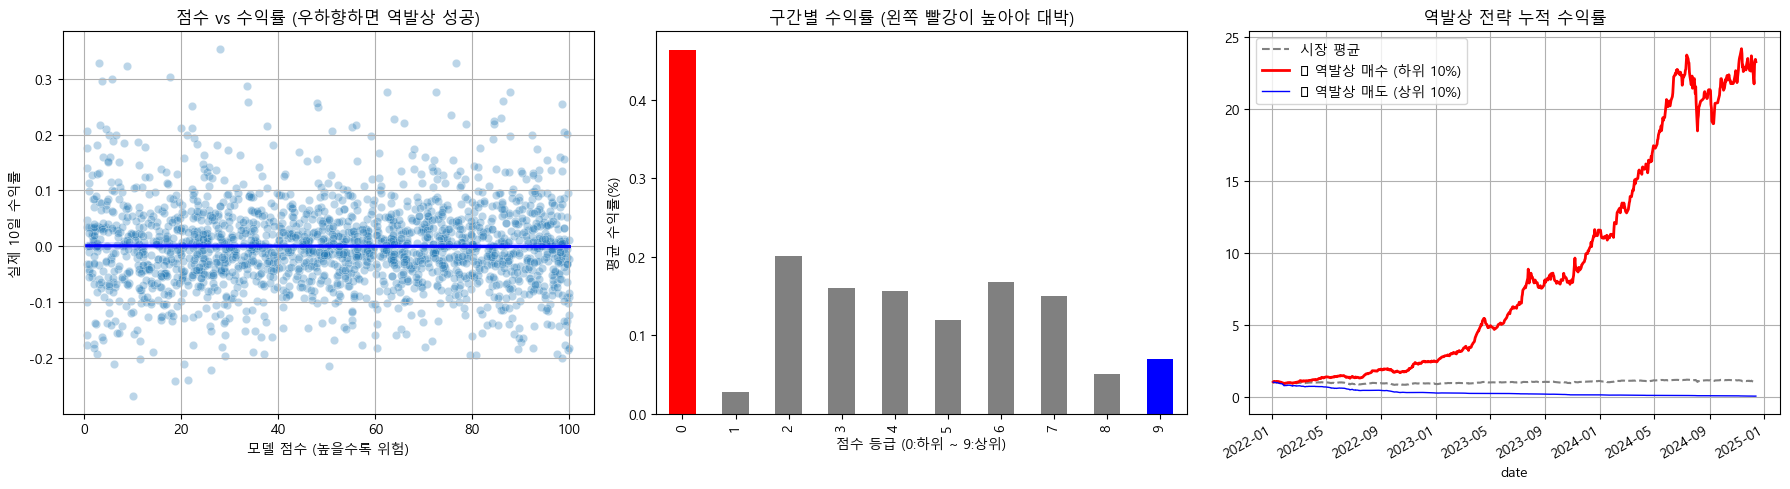

In [23]:
def verify_contrarian_strategy(df):
    if df.empty: return
    
    print("\n[🐸 청개구리 역발상 전략 최종 검증]")
    
    plt.figure(figsize=(18, 5))
    
    # ---------------------------------------------------------
    # (1) 산점도: 원래 모델과 반대로 가는지 확인
    # ---------------------------------------------------------
    plt.subplot(1, 3, 1)
    sample = df.sample(n=min(2000, len(df)), random_state=42)
    
    # X축: 모델 점수 (0~100)
    # Y축: 실제 수익률
    sns.scatterplot(x=sample['Score'], y=sample['target_return_10d'], alpha=0.3)
    
    # 추세선 그리기
    # 역발상 전략이 맞다면, 추세선이 "우하향(↘)" 하거나 평평할 것입니다.
    # (즉, 점수가 높을수록 수익률이 낮음)
    sns.regplot(x=sample['Score'], y=sample['target_return_10d'], scatter=False, color='blue')
    
    plt.title('점수 vs 수익률 (우하향하면 역발상 성공)')
    plt.xlabel('모델 점수 (높을수록 위험)'); plt.ylabel('실제 10일 수익률')
    plt.grid(True)
    
    # ---------------------------------------------------------
    # (2) 분위수 성과: "왼쪽(0번)"이 가장 높아야 함
    # ---------------------------------------------------------
    plt.subplot(1, 3, 2)
    df['Decile'] = pd.qcut(df['Score'], 10, labels=False, duplicates='drop')
    decile_ret = df.groupby('Decile')['target_return_10d'].mean() * 100
    
    # 색상 반전: 0번(하위)을 빨강(매수), 9번(상위)을 파랑(매도)으로 칠함
    colors = []
    for i in range(10):
        if i == 0: colors.append('red')      # 모델이 싫어한 놈 (강력 매수)
        elif i == 9: colors.append('blue')   # 모델이 좋아한 놈 (절대 매도)
        else: colors.append('gray')
        
    decile_ret.plot(kind='bar', color=colors)
    plt.title('구간별 수익률 (왼쪽 빨강이 높아야 대박)')
    plt.xlabel('점수 등급 (0:하위 ~ 9:상위)'); plt.ylabel('평균 수익률(%)')
    plt.axhline(0, color='black', linewidth=0.5)
    
    # ---------------------------------------------------------
    # (3) 누적 수익률 (전략 뒤집기 적용)
    # ---------------------------------------------------------
    plt.subplot(1, 3, 3)
    
    daily_market = df.groupby('date')['ret_1d'].mean()
    
    # ★ 전략 수정 ★
    # 모델 점수 하위 10% (Score <= 10) -> "역발상 매수 (New Top)"
    daily_contrarian_buy = df[df['Score'] <= 10].groupby('date')['ret_1d'].mean()
    
    # 모델 점수 상위 10% (Score >= 90) -> "역발상 매도 (New Bottom)"
    daily_contrarian_sell = df[df['Score'] >= 90].groupby('date')['ret_1d'].mean()
    
    # 누적 수익률 계산
    (1 + daily_market).cumprod().plot(label='시장 평균', color='gray', linestyle='--')
    (1 + daily_contrarian_buy).cumprod().plot(label='🐸 역발상 매수 (하위 10%)', color='red', linewidth=2)
    (1 + daily_contrarian_sell).cumprod().plot(label='⛔ 역발상 매도 (상위 10%)', color='blue', linewidth=1)
    
    plt.title('역발상 전략 누적 수익률')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 검증 실행
verify_contrarian_strategy(result_df)